<div class="">
    <h3>1. Data </h3>
</div>

<div class="">
    <h3>1.1  Data Cleaning</h3>
</div>

The dataset we have in hand includes information about house sales made in the city of Ames, Iowa between 2006 and 2010. During this period, a housing bubble occured in the United States (and Iowa) : national housing prices peaked in early 2007, showed a steep decline between 2007 and 2009 and started to recover between 2009 and 2010. Even though the local market in Ames, Iowa could have evolved differently, the date of the transaction should be something that we investigate further into later in our analyses as it is likely that it influences the prices.

<img src="Median_and_Average_Sales_Prices.png">

In [117]:
import os
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import math as mt
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import bokeh as bk
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV



base = "./data/"

We first load the data set as Data frames.

In [118]:
# Read the .csv file 
testDF = pd.read_csv(base + 'test.csv')
trainDF = pd.read_csv(base + 'train.csv')
testKaggleDF = pd.read_csv(base+ 'test_kaggle.csv')
# Print the size of the training set
print("Size of training set : "+str(trainDF['Id'].count()))

#Show some samples
print(trainDF[:5])

Size of training set : 1200
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  Sale

In our training set, there are 81 attributes(columns) and 1200 samples. We have 80 attributes in our testing set, as we do not have access to the prices. 

We will first treat missing values in those datasets.

In [119]:
# Compute number of missing values per attribute in the training set
trainSize = trainDF['Id'].count()
print("Size of training set : "+str(trainSize))
for label in trainDF.columns : 
    value_count = trainDF[label].count()
    if trainDF[label].count() != trainSize :
        print("  Number of missing values in "+label+" in training dataset : "+str(trainSize-trainDF[label].count()))
print("\n")

# Compute number of missing values per attribute in the testing set
testSize = testDF['Id'].count() 
print("Size of testing set : "+str(testSize))
for label in testDF.columns : 
    value_count = testDF[label].count()
    if testDF[label].count() != testSize :
        print("  Number of missing values in "+label+" in testing dataset : "+str(testSize-testDF[label].count()))

# Compute number of missing values per attribute in the testing set
testSize = testKaggleDF['Id'].count() 
print("Size of testing set : "+str(testSize))
for label in testKaggleDF.columns : 
    value_count = testKaggleDF[label].count()
    if testKaggleDF[label].count() != testSize :
        print("  Number of missing values in "+label+" in testing dataset : "+str(testSize-testKaggleDF[label].count()))



Size of training set : 1200
  Number of missing values in LotFrontage in training dataset : 210
  Number of missing values in Alley in training dataset : 1125
  Number of missing values in MasVnrType in training dataset : 6
  Number of missing values in MasVnrArea in training dataset : 6
  Number of missing values in BsmtQual in training dataset : 32
  Number of missing values in BsmtCond in training dataset : 32
  Number of missing values in BsmtExposure in training dataset : 33
  Number of missing values in BsmtFinType1 in training dataset : 32
  Number of missing values in BsmtFinType2 in training dataset : 33
  Number of missing values in FireplaceQu in training dataset : 564
  Number of missing values in GarageType in training dataset : 67
  Number of missing values in GarageYrBlt in training dataset : 67
  Number of missing values in GarageFinish in training dataset : 67
  Number of missing values in GarageQual in training dataset : 67
  Number of missing values in GarageCond in 

For most attributes with missing values, those values actually indicate the absence of the thing they refer to, for example LotFrontage or GarageType. For the part of those variables that are categorical, a good fix is to consider missing values as another category. Two variables with missing values are quantitative, LotFrontage and MasVnrArea. For LotFrontage it makes sense to consider missing values (which refers to house without any street connected to the property) as 0s. We will replace missing MasVnrArea values with its mean value, so that it does not affect the prediction too much.
GarageYrBlt is a categorial variable that is already encoded by numerical values, so we will change missing values to '-1' to create another category for those values.

The missing value in the testing set in Electrical looks like an exception. We will replace this value by the most frequent value which is SBrkr, so that it has the smallest impact possible on the prediction.

In [120]:
# Handle missing Electrical values
testDF.loc[testDF['Electrical'].isnull(),'Electrical'] = 'SBrkr'
testKaggleDF.loc[testKaggleDF['Electrical'].isnull(),'Electrical'] = 'SBrkr'

#Handle missing LotFrontage values
testDF.loc[testDF['LotFrontage'].isnull(),'LotFrontage'] = 0
trainDF.loc[trainDF['LotFrontage'].isnull(),'LotFrontage'] = 0
testKaggleDF.loc[testKaggleDF['LotFrontage'].isnull(),'LotFrontage'] = 0

#Handle missing MasVnrArea values
testDF.loc[testDF['MasVnrArea'].isnull(),'MasVnrArea'] = testDF['MasVnrArea'].mean()
trainDF.loc[trainDF['MasVnrArea'].isnull(),'MasVnrArea'] = testDF['MasVnrArea'].mean()
testKaggleDF.loc[testKaggleDF['MasVnrArea'].isnull(),'MasVnrArea'] = testKaggleDF['MasVnrArea'].mean()
testDF.loc[testDF['MasVnrType'].isnull(),'MasVnrType'] = 'BrkCmn'
trainDF.loc[trainDF['MasVnrType'].isnull(),'MasVnrArea'] = 'BrkCmn'
testKaggleDF.loc[testKaggleDF['MasVnrType'].isnull(),'MasVnrType'] = 'BrkCmn'

#Handle missing GarageYrBlt values
testDF.loc[testDF['GarageYrBlt'].isnull(),'GarageYrBlt'] = testDF['GarageYrBlt'].mean()
trainDF.loc[trainDF['GarageYrBlt'].isnull(),'GarageYrBlt'] = testDF['GarageYrBlt'].mean()
testKaggleDF.loc[testKaggleDF['GarageYrBlt'].isnull(),'GarageYrBlt'] = testKaggleDF['GarageYrBlt'].mean()


testKaggleDF.loc[testKaggleDF['MSZoning'].isnull(),'MSZoning'] = 'RM'
testKaggleDF.loc[testKaggleDF['Exterior1st'].isnull(),'Exterior1st'] = 'CBlock'
testKaggleDF.loc[testKaggleDF['Exterior2nd'].isnull(),'Exterior2nd'] = 'CBlock'
testKaggleDF.loc[testKaggleDF['BsmtFinSF1'].isnull(),'BsmtFinSF1'] = 0
testKaggleDF.loc[testKaggleDF['BsmtFinSF2'].isnull(),'BsmtFinSF2'] = 0
testKaggleDF.loc[testKaggleDF['BsmtUnfSF'].isnull(),'BsmtUnfSF'] = 0
testKaggleDF.loc[testKaggleDF['TotalBsmtSF'].isnull(),'TotalBsmtSF'] = 0
testKaggleDF.loc[testKaggleDF['BsmtFullBath'].isnull(),'BsmtFullBath'] = 0
testKaggleDF.loc[testKaggleDF['BsmtHalfBath'].isnull(),'BsmtHalfBath'] = 0
testKaggleDF.loc[testKaggleDF['KitchenQual'].isnull(),'KitchenQual'] = 'TA'
testKaggleDF.loc[testKaggleDF['Functional'].isnull(),'Functional'] = 'Typ'
testKaggleDF.loc[testKaggleDF['SaleType'].isnull(),'SaleType'] = 'WD'
testKaggleDF.loc[testKaggleDF['GarageCars'].isnull(),'GarageCars'] = 0
testKaggleDF.loc[testKaggleDF['GarageArea'].isnull(),'GarageArea'] = 0




The other missing values will be handled in the next step, during which we treat categorial variables.

In [121]:
# Compute number of missing values per attribute in the testing set
testSize = len(testKaggleDF)
print("Size of testing set : "+str(testSize))
for label in testKaggleDF.columns : 
    value_count = testKaggleDF[label].count()
    if testKaggleDF[label].count() != testSize :
        print("  Number of missing values in "+label+" in testing dataset : "+str(testSize-testKaggleDF[label].count()))

Size of testing set : 1459
  Number of missing values in Alley in testing dataset : 1352
  Number of missing values in Utilities in testing dataset : 2
  Number of missing values in BsmtQual in testing dataset : 44
  Number of missing values in BsmtCond in testing dataset : 45
  Number of missing values in BsmtExposure in testing dataset : 44
  Number of missing values in BsmtFinType1 in testing dataset : 42
  Number of missing values in BsmtFinType2 in testing dataset : 42
  Number of missing values in FireplaceQu in testing dataset : 730
  Number of missing values in GarageType in testing dataset : 76
  Number of missing values in GarageFinish in testing dataset : 78
  Number of missing values in GarageQual in testing dataset : 78
  Number of missing values in GarageCond in testing dataset : 78
  Number of missing values in PoolQC in testing dataset : 1456
  Number of missing values in Fence in testing dataset : 1169
  Number of missing values in MiscFeature in testing dataset : 1408

The attributes of our dataset are divided in 2 types: quantitative and categorial. One exception is MSSubClass, which takes numerical values that actually refers to categories. As many machine learning only work on numerical values, we will transform the data in order to encode categorial variables with numerical values. Categorial attributes can also be divided based on if they possess an obvious order relation or not, for example ExterQual and Foundation. We should treat non-ordered categorial variables differently when computing descriptive statistics about our data.


In [122]:


#Keep non ordered variables labels in memory
non_ordered_columns=['Id','MSSubClass','MSZoning','Street', 'Alley', 'LotShape', 'LandContour', 
                        'LotConfig', 'LandSlope' ,'Neighborhood', 'Condition1', 'Condition2',
                        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                        'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType',
                        'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

#Cast columns to type category and create new columns with numerical values
cat_columns = trainDF.columns[trainDF.dtypes=="object"].tolist()


for column in cat_columns :
    trainDF[column]=trainDF[column].astype("category")

#Do the same for testing set
for column in cat_columns :
    testDF[column] = testDF[column].astype('category')

#Do the same for testing set
for column in cat_columns :
    testKaggleDF[column] = testKaggleDF[column].astype('category')

#Add labels of "fake" numerical variables to cat_columns
cat_columns.append('MSSubClass')
cat_columns.append('MoSold')

#Show some samples
print(trainDF[:5])

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008     

We can notice that missing values in categorial variables have been replaced by '-1', which defines another category as we intended.

Now that we have a clean dataset, let's take a look at SalePrice, the variable we are trying to predict : 

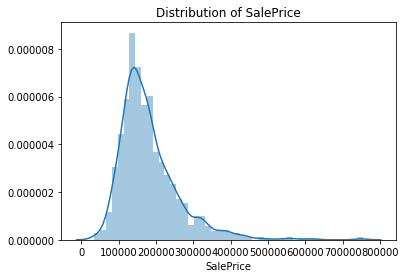

count      1200.000000
mean     181414.628333
std       81070.908544
min       34900.000000
25%      129900.000000
50%      163700.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [123]:
fig, ax = plt.subplots()
sns.distplot(trainDF['SalePrice'])
ax.set_title('Distribution of SalePrice')
ax.set_xlabel('SalePrice')
plt.show()
print(trainDF['SalePrice'].describe())

As expected, SalePrice's distribution is quite concentrated, as few people could afford to buy very expensive houses and few houses are sold at a very low price. However, SalePrice does not fit a normal distribution. In order to increase the efficiency of our algorithm, we will have to transform it later on into a normal distribution.

Then, we can compute the distribution of our variables to get a better understanding of them.

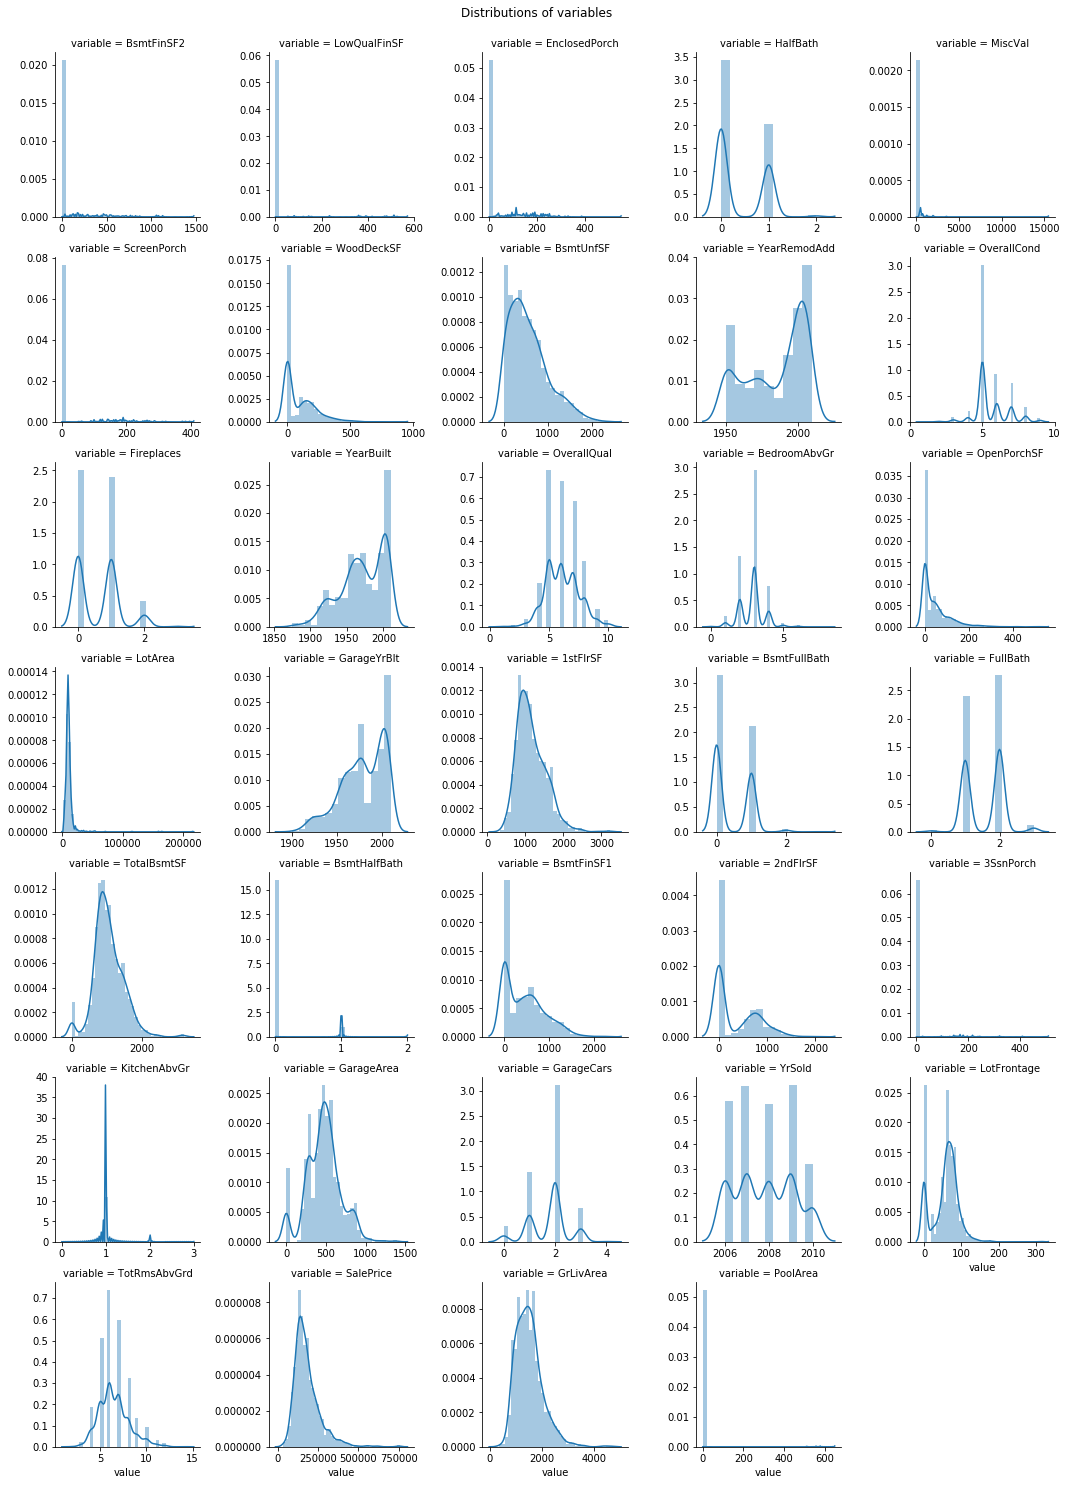

In [124]:
#Select quantitative columns
qua_columns = list(set(trainDF.columns)-{'Id'}-set(cat_columns))

#Plot histogram and kde for those columns
f = pd.melt(trainDF, value_vars=qua_columns)
g = sns.FacetGrid(f, col='variable',  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Distributions of variables');

We can already get some insight from those plots. Some variables like GrLivArea, TotalBsmtSF or 1stFlrSF have distributions which show "normal-like" behavior. Our predictions could benefit from those variables being transformed to fit a normal distribution. 
Other variables, like Condition2 or Utilities have the same value in nearly all observations. It might be interesting to look at the observations in which those variables differ.
A lot of the distributions such as 3SsnPorch's or ScreenPorch's exhibit a spike at 0 which is linked to observations for whom those variables are irrelevant, as the house does not have the related feature.

We will now plot the distribution of each of our predictive variables regarding SalePrice, beginning with quantitative variables. 

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice]
Index: []

[0 rows x 81 columns]


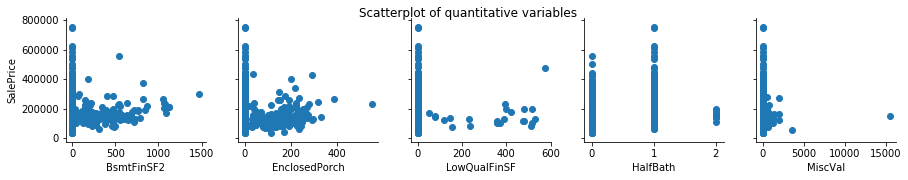

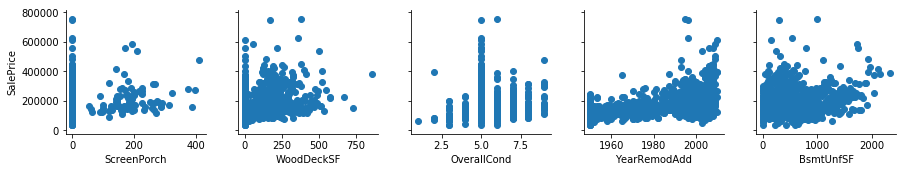

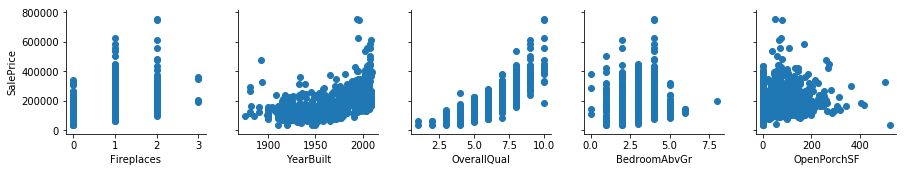

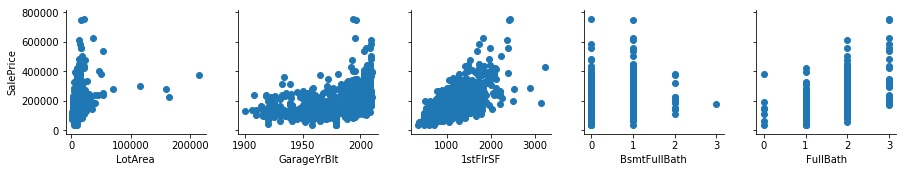

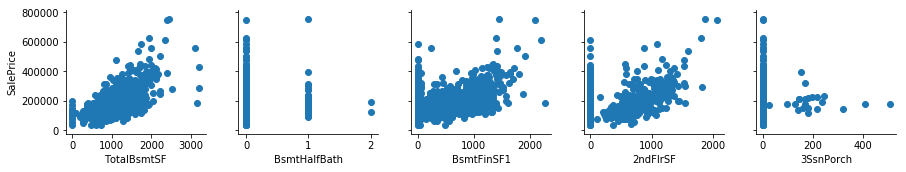

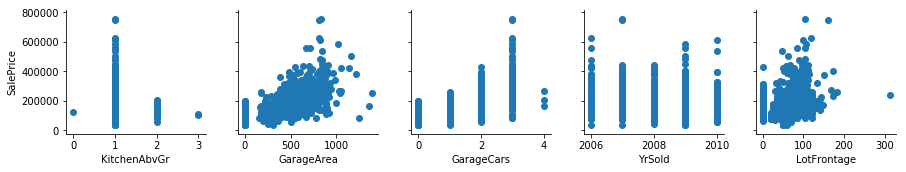

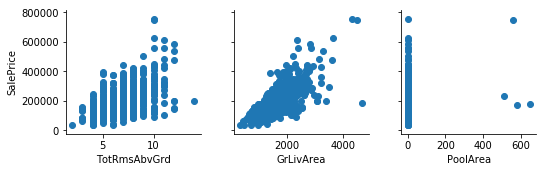

In [125]:
#Select quantitative columns
qua_columns = list(set(trainDF.columns)-set(cat_columns)-{"SalePrice","Id"})

#Plot scatterplots for quantitative columns
g = sns.PairGrid(trainDF,x_vars=qua_columns[:5], y_vars=['SalePrice'])
g = g.map(plt.scatter)
g.fig.suptitle('Scatterplot of quantitative variables');
for i in range(1,7): #We manually plot only 5 per row for better lisibility
    g = sns.PairGrid(trainDF,x_vars=qua_columns[5*i:5*(i+1)], y_vars=['SalePrice'])
    g = g.map(plt.scatter) 
trainDF = trainDF[trainDF.Id!=524]
print(trainDF[trainDF.Id==524])

We can see in those scatterplots that some variables exhibit a linear relationship with SalePrice, namely OverallQual, 1stFlrSF, 2ndFlrSF, GrLivArea, FullBath, TotRmsAbvGrd, GarageCars. BedroomAbvGrd. TotalBsmtSF, BsmtFinSF1, BsmtFinSF2 and GarageArea also show this kind of behaviour, if we exclude the observation with value 0, which represent the absence of the thing the variable refers to. 
It makes sense because those variables are all derivative of the size of the house, and houses are normally sold at a price proportional to their size. 

Some data point seem particularly odd : we can see in the graph of GrLivArea that one really big house (more than 4000 square feet) has been sold at a very low price. When we look at this observation. We should drop this observation from the dataset so that it does not affect the predictions, as it clearly seems to be an outlier, and it is unlikely a property in the testing set will have the same characteristics.

Two other observations, which involve really big house, can be considered as outliers. Yet, they are adequately priced, and might carry useful information for our model. We will therefore only remove the first outlier.
We can also see that only a few of the houses have a pool. We could simplify our model by removing features related to pools and keeping only one variable, which would encode the presence of a pool or not.

In [126]:
trainDF = trainDF[trainDF.Id!=524]

print(len(trainDF["GarageCond"].isin(["Po"])))

1199


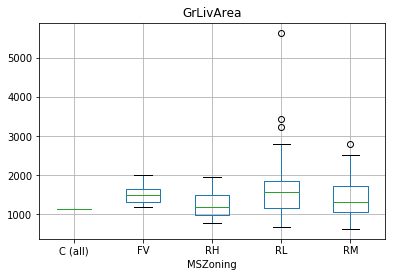

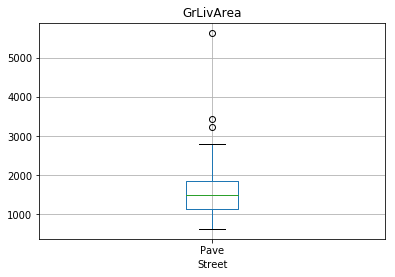

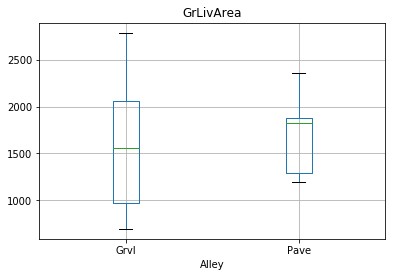

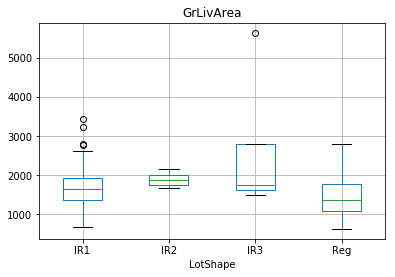

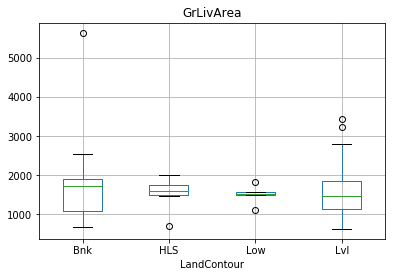

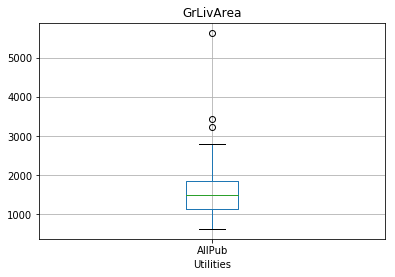

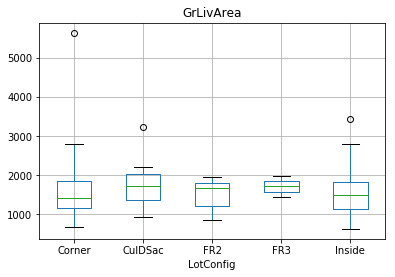

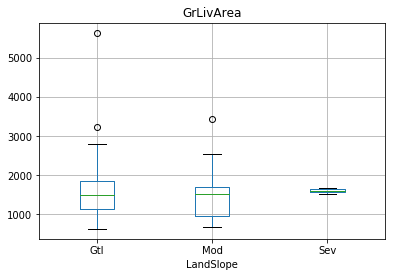

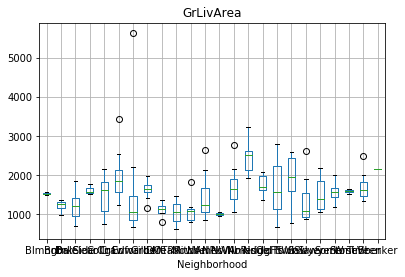

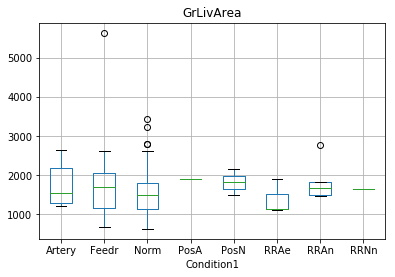

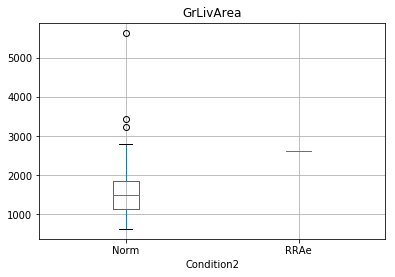

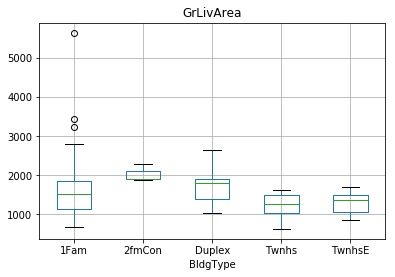

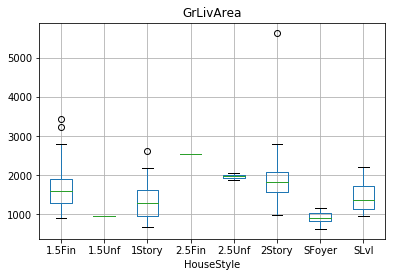

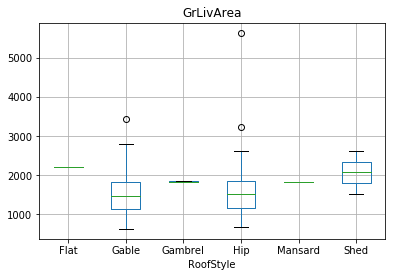

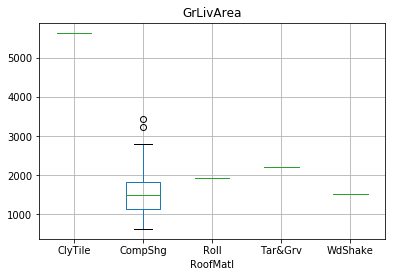

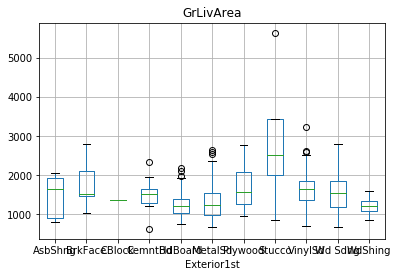

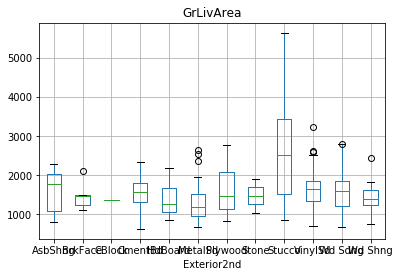

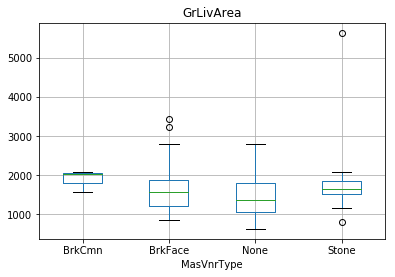

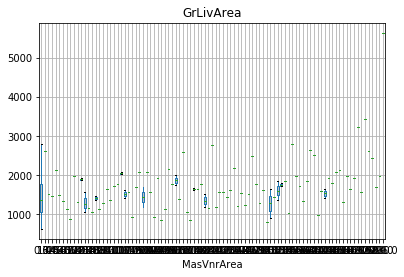

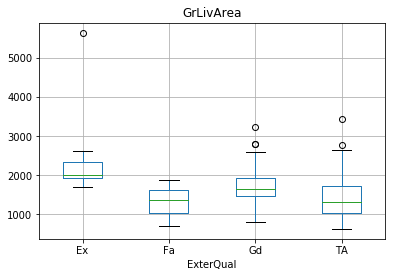

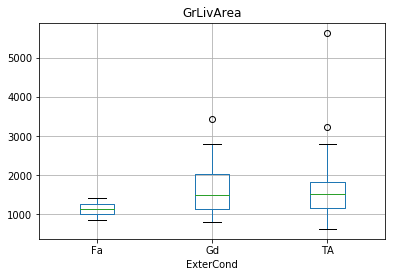

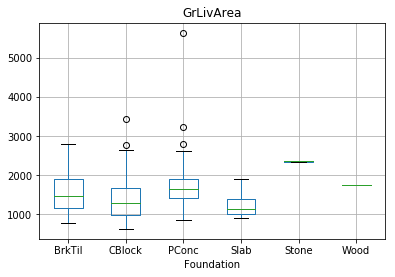

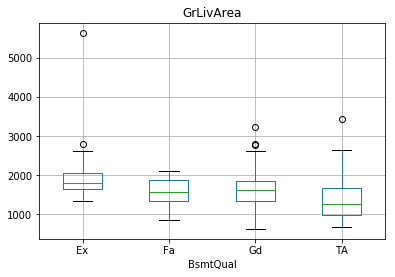

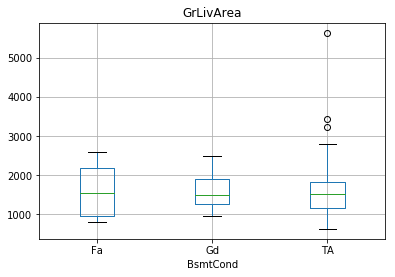

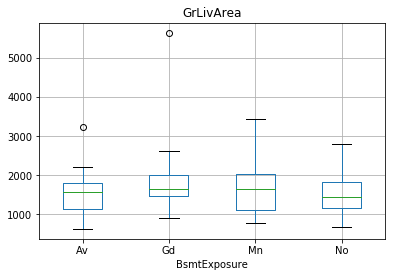

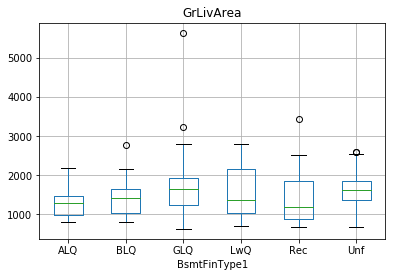

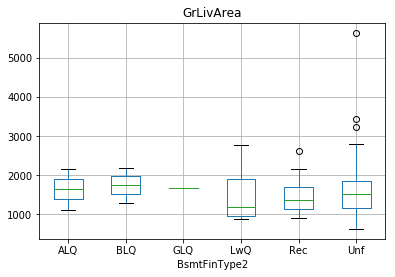

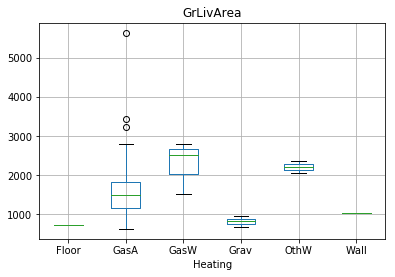

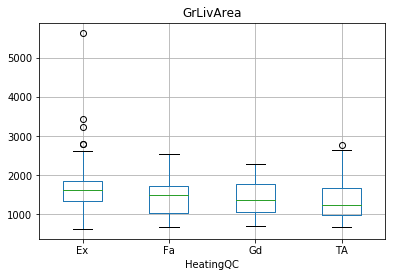

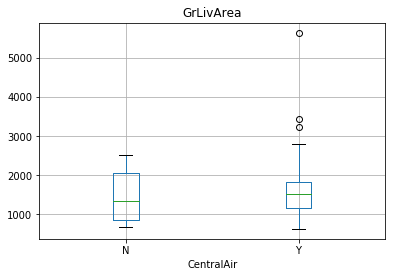

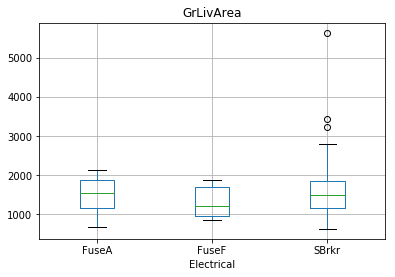

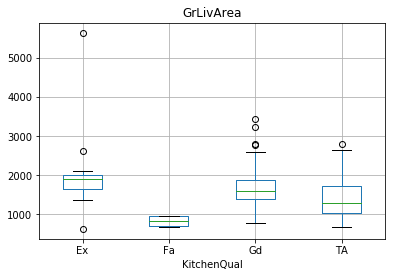

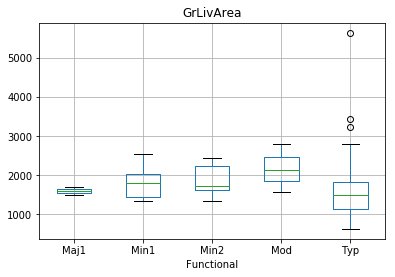

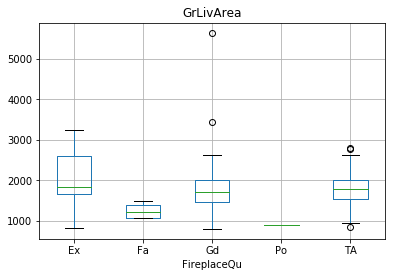

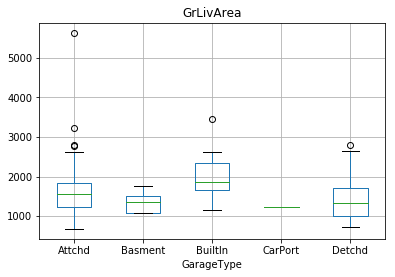

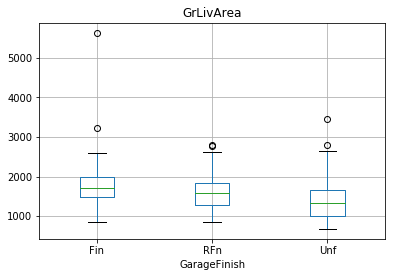

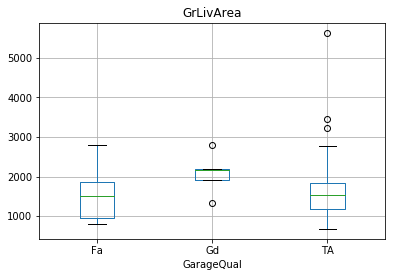

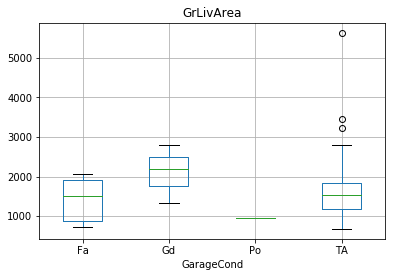

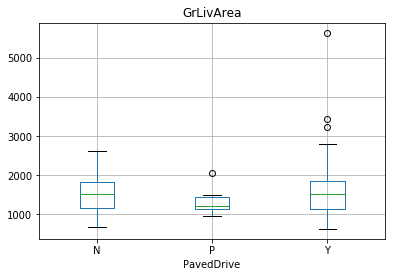

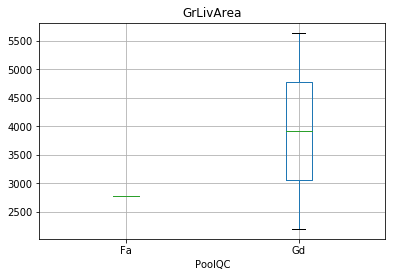

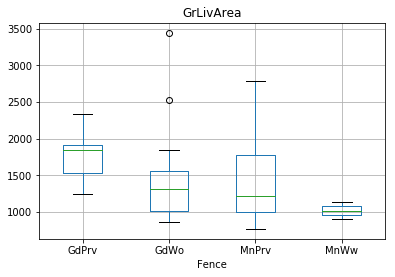

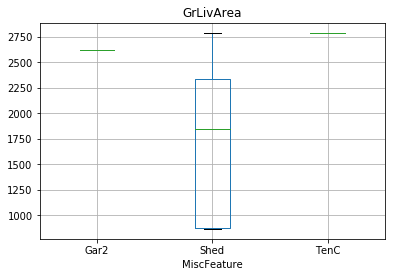

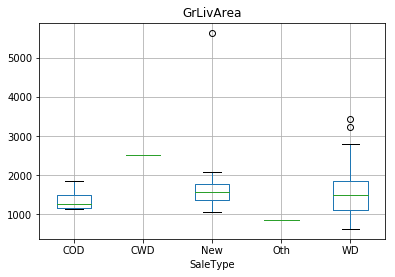

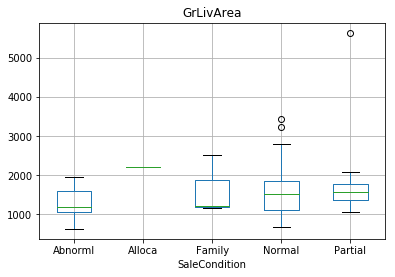

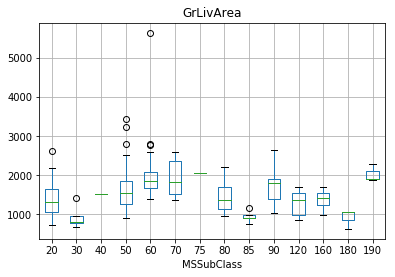

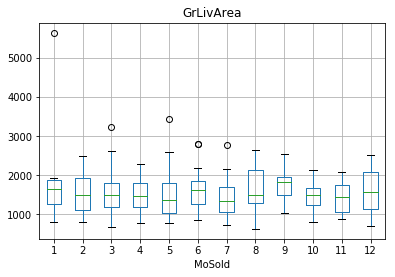

In [127]:
#Plot boxplots for categorical columns
# It would be nicer to plot them smaller and with 3 plots by row 
for label in cat_columns :
    testDF.boxplot(column = 'GrLivArea', by = label)
    plt.suptitle("")
    plt.show()

Let's now plot the distribution of the categorical variables.

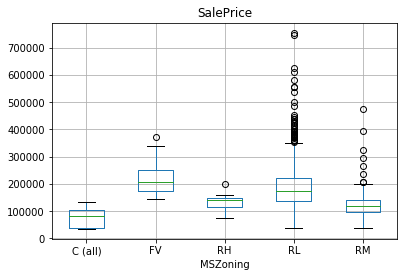

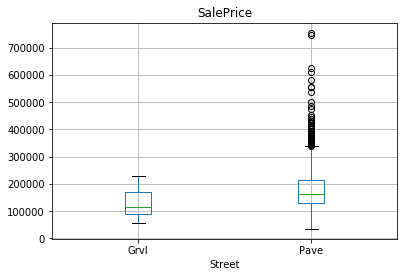

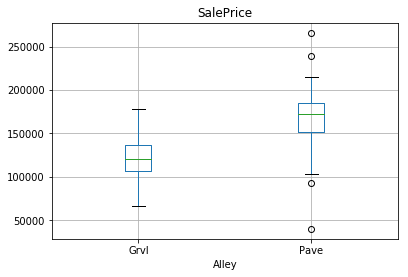

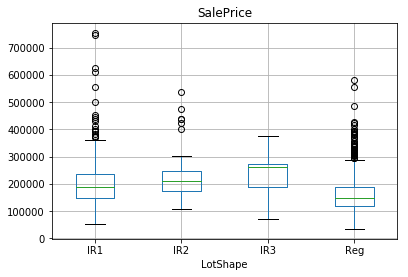

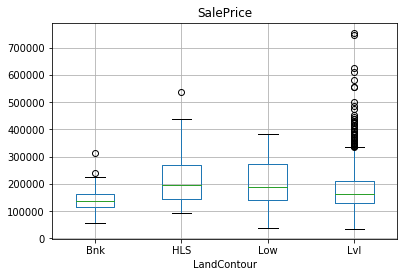

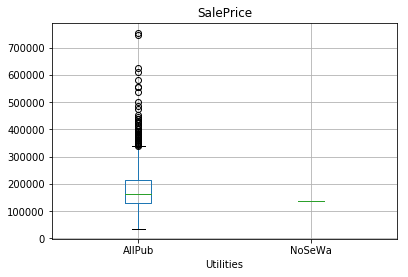

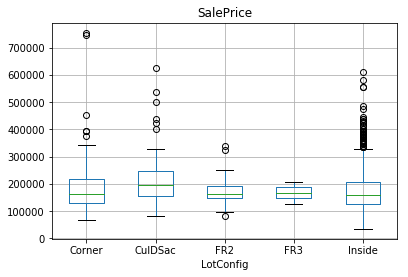

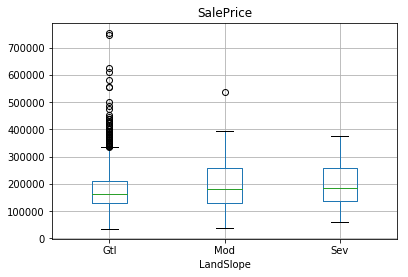

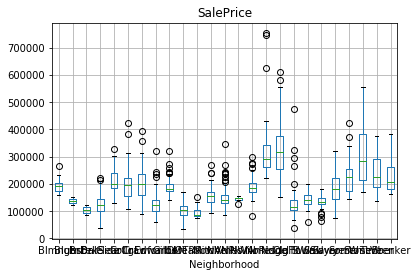

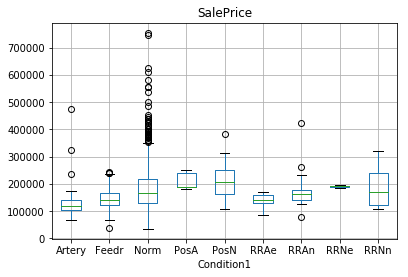

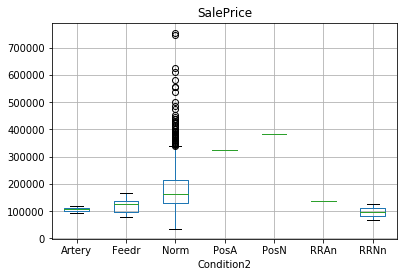

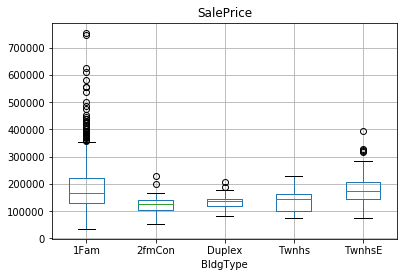

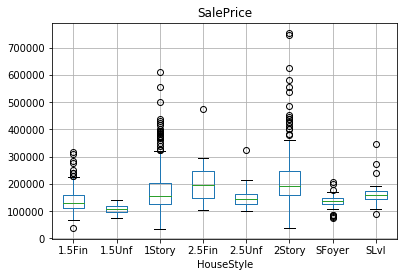

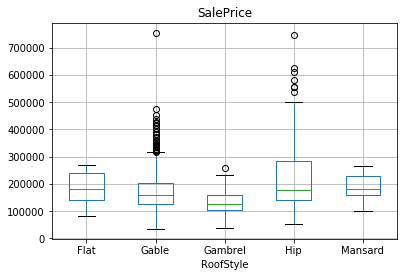

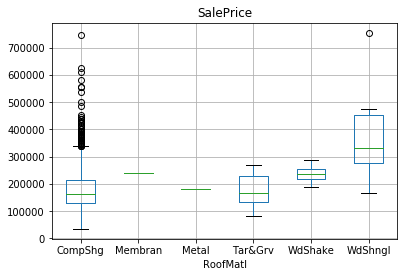

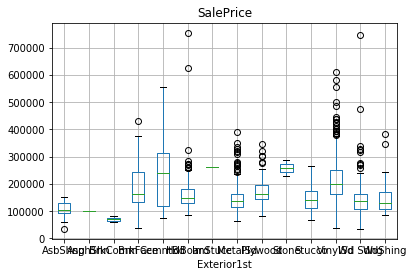

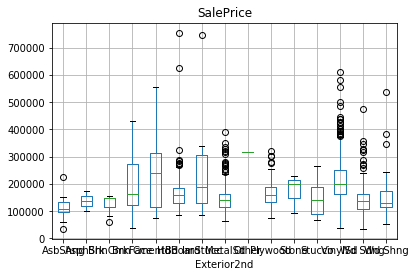

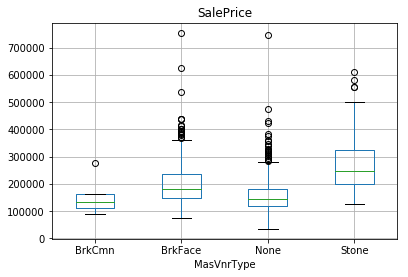

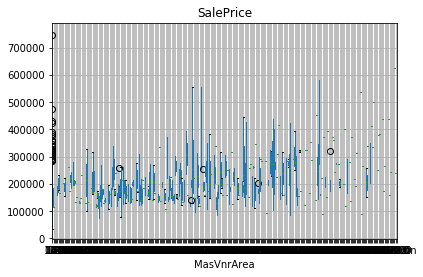

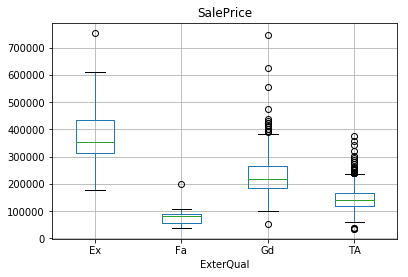

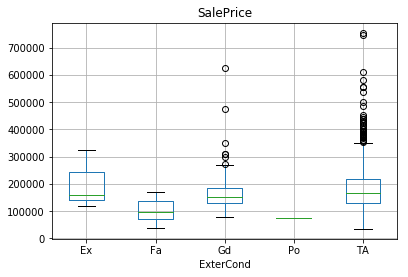

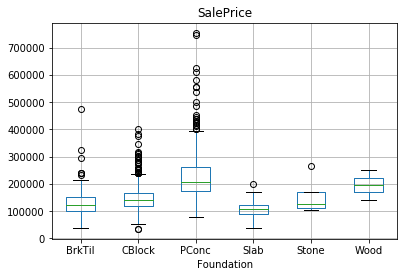

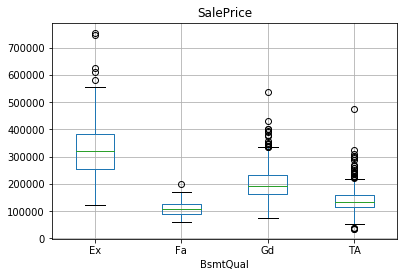

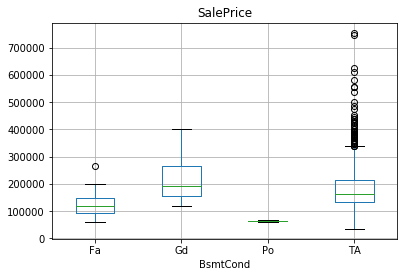

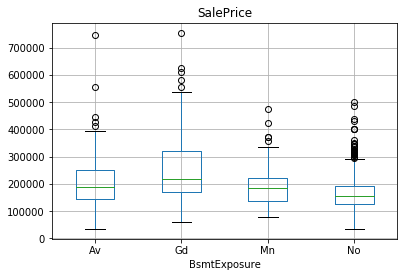

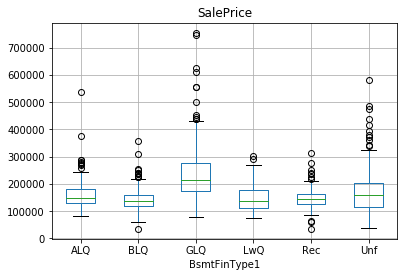

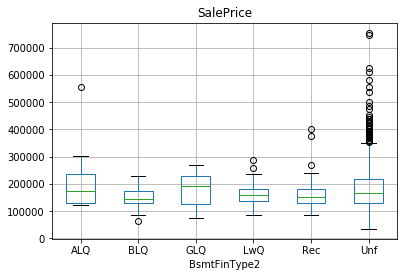

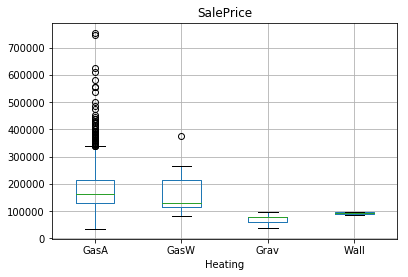

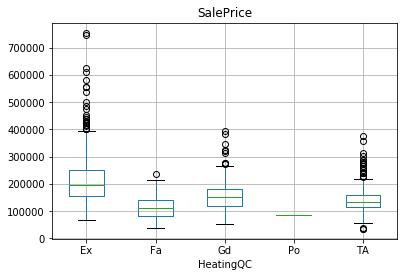

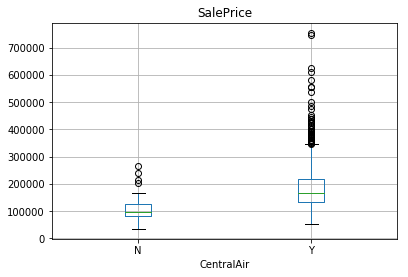

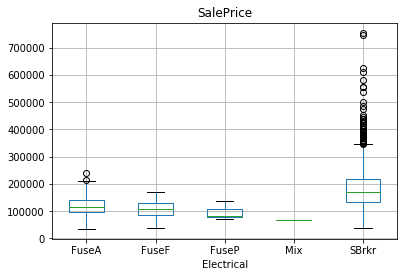

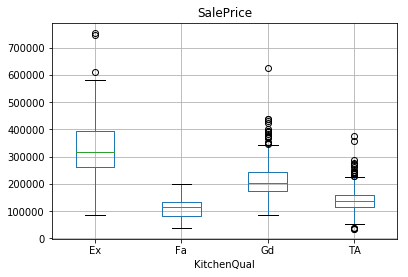

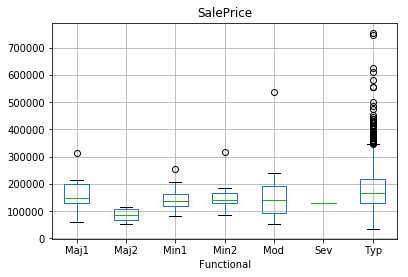

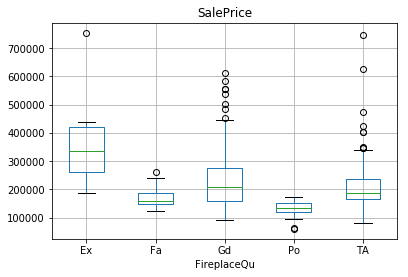

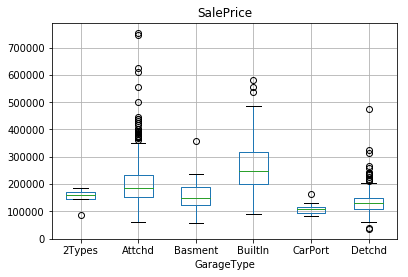

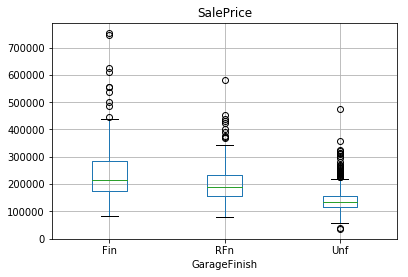

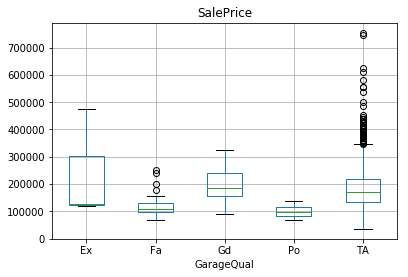

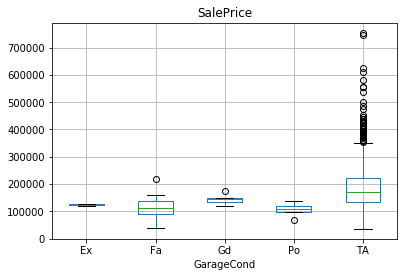

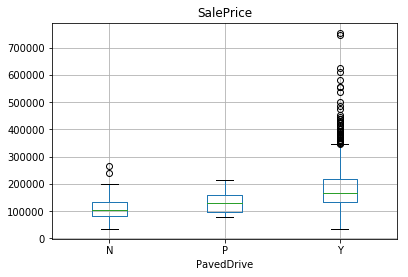

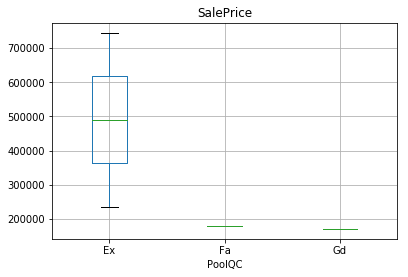

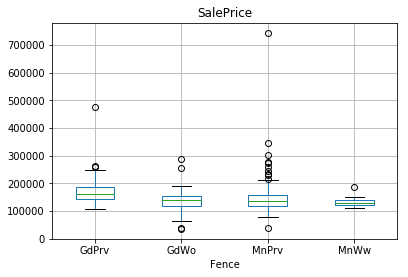

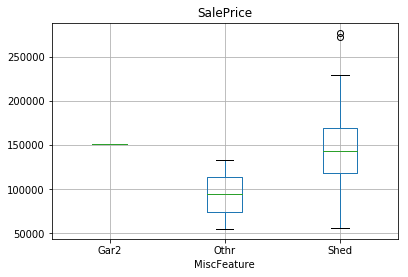

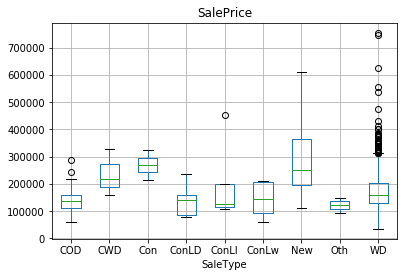

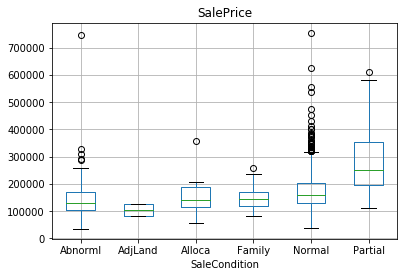

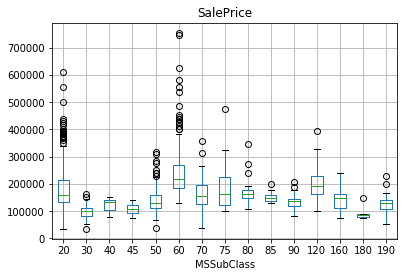

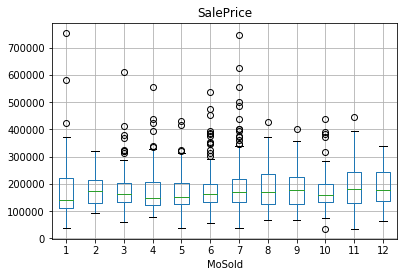

In [128]:
#Plot boxplots for categorical columns
# It would be nicer to plot them smaller and with 3 plots by row 
for label in cat_columns :
    trainDF.boxplot(column = 'SalePrice', by = label)
    plt.suptitle("")
    plt.show()

Street : no house with 0 Street cost more than 250000 or so
Utilities should be dropped, highly likely overfit if house with 1 value, and no info if 0
Neighborhood : some are strongly determining the prices, others more loosely (wider range of prices). to inspect deeper
Condition1 7 (close to railways) looks interesting. Few samples but very close in price. It seems location is key for bad in some areas.
Some values only appear in a very small number of observations. We should treat those cases during the preprocessing because it can be a cause of overfitting.

We will now investigate into correlations between variables. 
(Since many of our variables are categorical and many usual correlation metrics only apply to numerical values, we will need to use different metrics to calculate correlation of pairs of categorical-numerical, numerical-numerical, numerical-categorical and categorical-categorical variables. Furthermore, the metrics we use have to be comparable.
categorical-numerical : we can calculate how much mean in each category deviates from the global average. => between 0 and 1, encodes force of the link 
cat-cat : chi-square test
"Significance tests:)

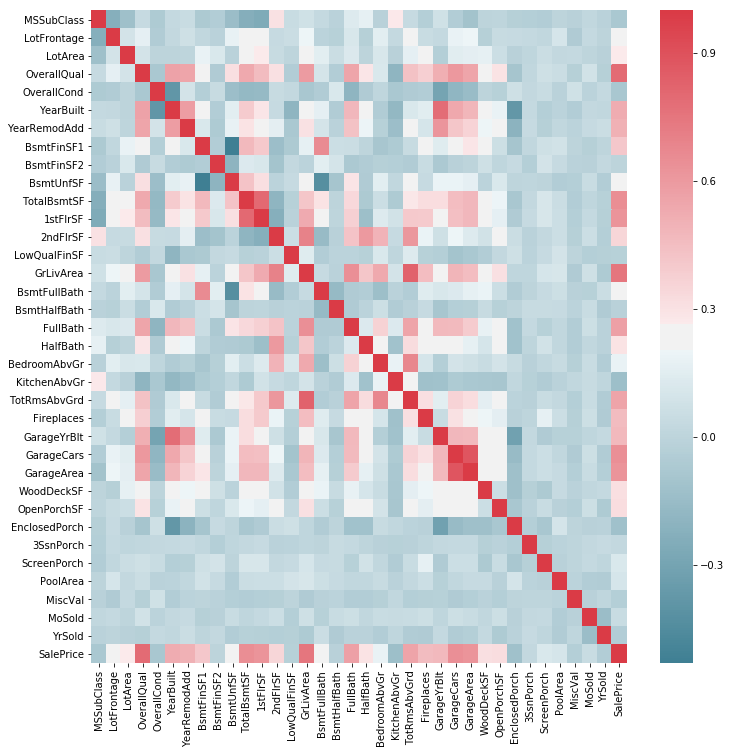

In [129]:
corrmat = trainDF.drop(['Id'],axis=1).corr()
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corrmat, cmap=cmap);

Here the lighter the colour is, the more the parameters are correlated.
We notice that the correlations between parameters and SalePrice are not homogenous; there is some parameters that have greater impact on the price than others, for example : OverallQual, GrLivArea, GarargeArea .. this should be taken into account during the learning process.

The parameters of our dataset is divided in 2 types: quantitative and categorical.   

First some examples of the quantitative data : 

Text(0.5,1,'SalePrice as a function of GarageArea')

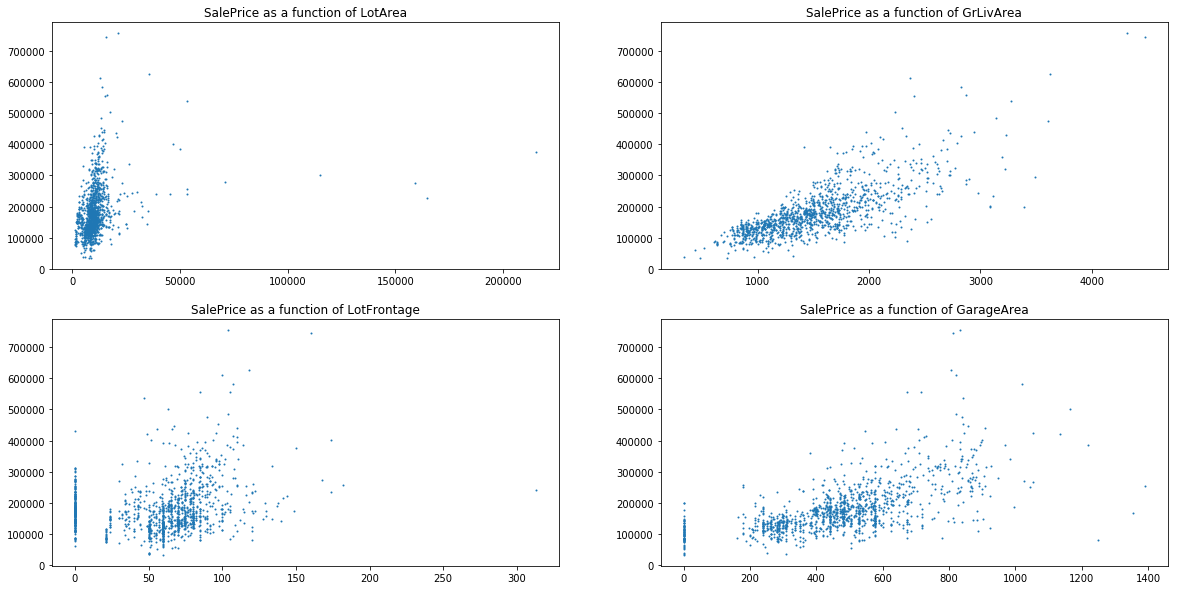

In [130]:
plt.subplots(figsize=(20,10))
plt.subplot(2,2,1)
plt.scatter(trainDF['LotArea'],trainDF['SalePrice'],s=1)
plt.title('SalePrice as a function of LotArea')

plt.subplot(2,2,2)
plt.scatter(trainDF['GrLivArea'],trainDF['SalePrice'],s=1)
plt.title('SalePrice as a function of GrLivArea')

plt.subplot(2,2,3)
plt.scatter(trainDF['LotFrontage'],trainDF['SalePrice'],s=1)
plt.title('SalePrice as a function of LotFrontage')

plt.subplot(2,2,4)
plt.scatter(trainDF['GarageArea'],trainDF['SalePrice'],s=1)
plt.title('SalePrice as a function of GarageArea')

We need to clean the data by removing the outliers.

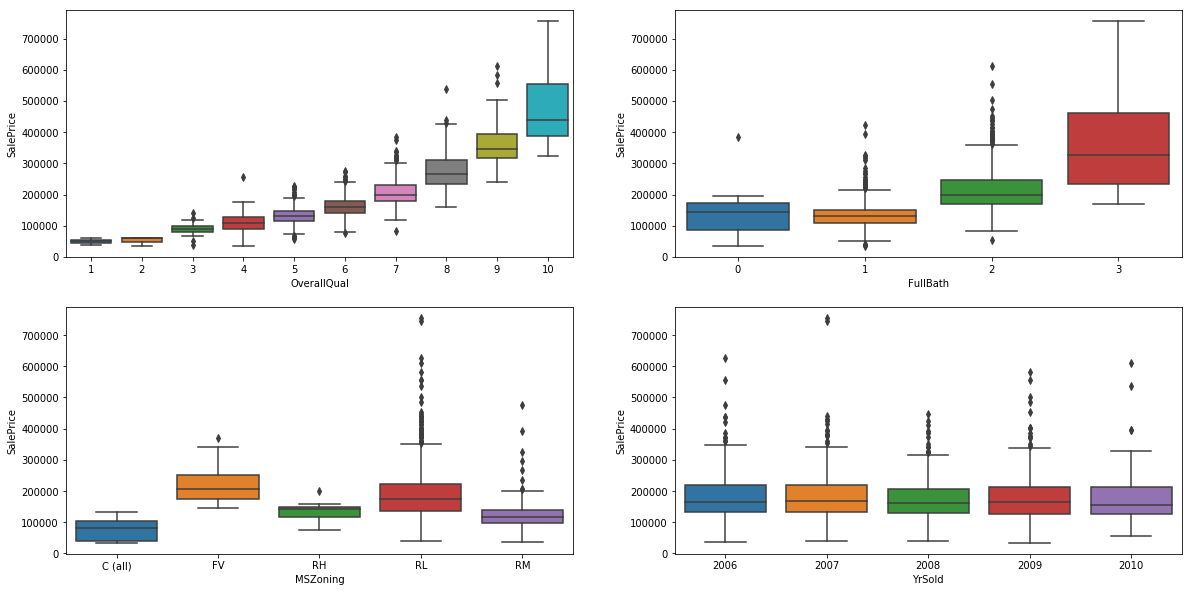

In [131]:
plt.subplots(figsize=(20,10))

plt.subplot(2,2,4)
data = pd.concat([trainDF['SalePrice'],trainDF['YrSold']], axis = 1)
fig =sns.boxplot(x='YrSold', y='SalePrice', data=data)

plt.subplot(2,2,3)
data = pd.concat([trainDF['SalePrice'],trainDF['MSZoning']], axis = 1)
fig =sns.boxplot(x='MSZoning', y='SalePrice', data=data)

plt.subplot(2,2,1)
data = pd.concat([trainDF['SalePrice'],trainDF['OverallQual']], axis = 1)
fig =sns.boxplot(x='OverallQual', y='SalePrice', data=data)

plt.subplot(2,2,2)
data = pd.concat([trainDF['SalePrice'],trainDF['FullBath']], axis = 1)
fig =sns.boxplot(x='FullBath', y='SalePrice', data=data)

We notice again the difference in the correlation between different parameter
s : the OverallQual has obviously more impact on the price then the YrSold.

<div class="">
    <h3>1.2 Data preprocessing</h3>
</div>

Encoding of categorical features



We encode categorical features using an integer to represent each class, and -1 to represent a missing value.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


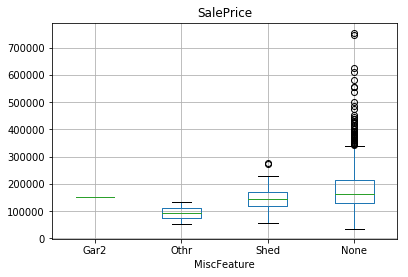

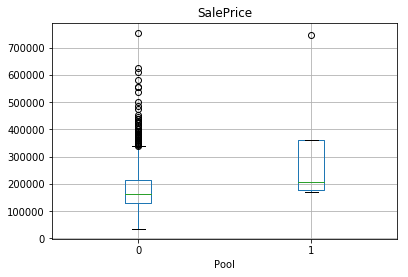

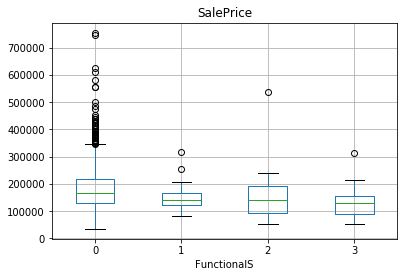

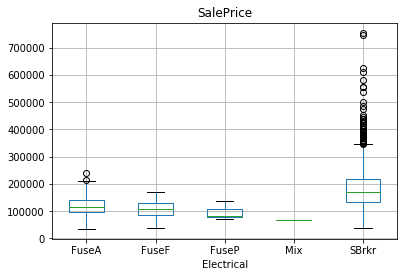

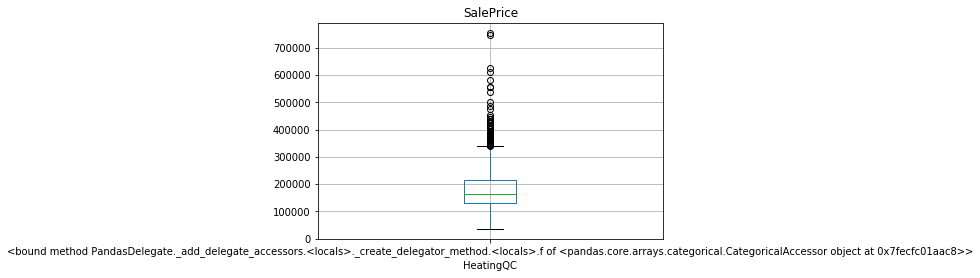

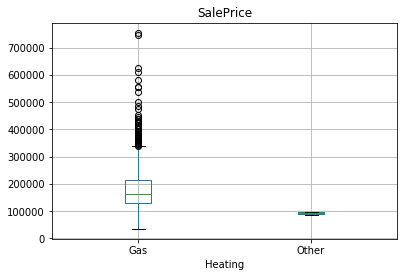

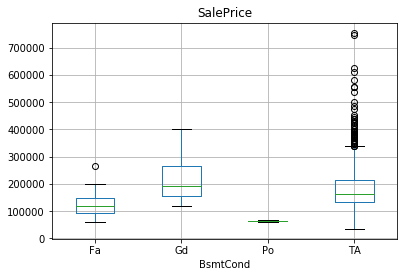

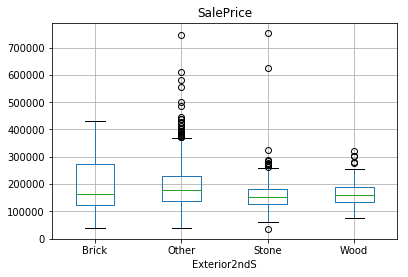

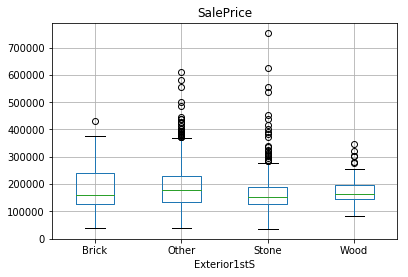

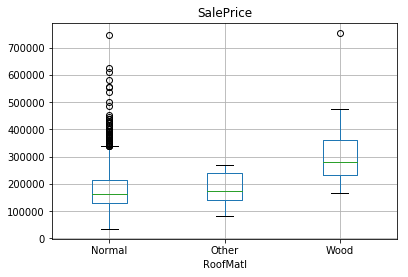

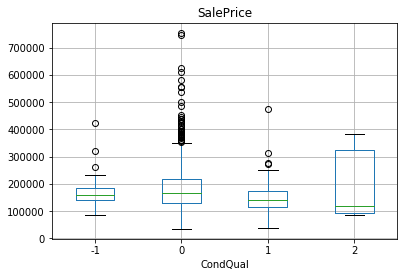

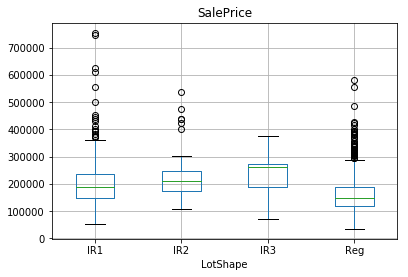

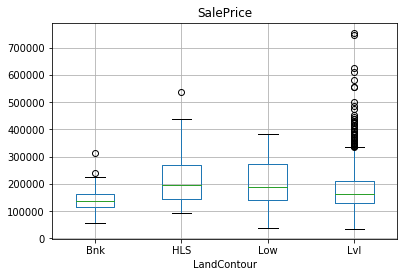

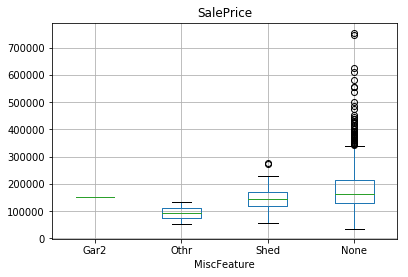

In [132]:
def nominal_variables_transfo(df):
    #Deal with LotShape
    mapping = {"IR1":"IReg","IR2":"IReg","IR3":"IReg","Reg":"Reg"}
    df["LotShapeBin"] = df.LotShape.map(mapping)

    #Deal with LandContour
    mapping = {"Lvl":"Reg","Bnk":"IReg","HLS":"Ireg","Low":"Ireg"}
    df["LotContourBin"] = df.LandContour.map(mapping)

    #Create new columns summing good or bad conditions
    mapping = {"Artery":1,"Feedr":1,"PosN":1,"PosA":1,"RRNn":-1,"RRAn":-1,"RRNe":-1,"RRAe":-1,"Norm":0}
    df["CondQual1"] = df.Condition1.map(mapping) 
    df["CondQual2"] = df.Condition2.map(mapping)
    df["CondQual1"] = df["CondQual1"].fillna(0)
    df["CondQual2"] = df["CondQual2"].fillna(0)
    df["CondQual"] = df.apply(lambda row : row.CondQual1 + row.CondQual2,axis=1)

    #Simplify RoofMatl
    mapping = {"CompShg":"Normal","Membran":"Other","WdShake":"Wood","WdShngl":"Wood","Metal":"Other","Tar&Grv":"Other","Roll":"Other","ClyTile":"Other"}
    df["RoofMatl"] = df.RoofMatl.map(mapping)


    #Simplify Exterior1st
    mapping = {"BrkComm":"Brick","BrkFace":"Brick","AsbShng":"Stone","AsphShn":"Stone","CBlock":"Stone",
          "CemntBd":"Stone","HdBoard":"Stone","ImStucc":"Other","MetalSd":"Other","Other":"Other",
           "Plywood":"Wood","PreCast":"Other","Stone":"Stone", "Stucco":"Other","VinylSd":"Other",
          "WdSdng":"Other","WdShing":"Other"}
    df["Exterior1stS"] = df.Exterior1st.map(mapping)

    #Simplify Exterior2nd
    mapping = {"BrkComm":"Brick","BrkFace":"Brick","AsbShng":"Stone","AsphShn":"Stone","CBlock":"Stone",
          "CemntBd":"Stone","HdBoard":"Stone","ImStucc":"Other","MetalSd":"Other","Other":"Other",
           "Plywood":"Wood","PreCast":"Other","Stone":"Stone", "Stucco":"Other","VinylSd":"Other",
          "WdSdng":"Other","WdShing":"Other"}
    df["Exterior2ndS"] = df.Exterior2nd.map(mapping)

    #Change Poor to No Basement in BsmtCond
    df[df["BsmtCond"]=="Po"]["BsmtCond"] = np.nan

    #Simplify Heating
    mapping = {"Floor":"Other","GasA":"Gas","GasW":"Gas","OthW":"Other","Wall":"Other"}
    df["Heating"] = df.Heating.map(mapping)

    #Change Po to Fa in HeatingQC, as there is not enough observations of poor heating
    df["HeatingQC"] = df["HeatingQC"].replace(["Po"],"Fa")
    df["HeatingQC"] = df["HeatingQC"].cat.remove_unused_categories


    #Make Electrical binary
    mapping = {"SBrkr":0,"Mix":0,"FuseA":1,"FuseF":1,"FuseP":1}
    df["ElectricalBin"] = df.Electrical.map(mapping)

    #Simplify Functional
    mapping = {"Typ":0,"Min1":1,"Min2":1,"Mod":2,"Maj1":3,"Maj2":3,"Sev":3,"Sal":5}
    df["FunctionalS"] = df.Functional.map(mapping)


    #Add column for the presence of a pool, delete the others refering to it
    mapping = {"Ex":1,"Gd":1,"TA":1,"Fa":1,np.nan:0}
    df["Pool"] = df.PoolQC.map(mapping)


    #Make MiscFeature binary
    mapping = {'Elev':1,'Gar2':1,'Othr':1,'Shed':1,'TenC':1, 'None':0}
    df["MiscFeature"].cat.add_categories(["None"],inplace=True)
    df["MiscFeature"] = df["MiscFeature"].fillna('None')
    df["MiscFeatureBin"] = df.MiscFeature.map(mapping)
    

nominal_variables_transfo(trainDF)
nominal_variables_transfo(testDF)
nominal_variables_transfo(testKaggleDF)

#Plot boxplots to see changes
changed_col = ["MiscFeature","Pool","FunctionalS","Electrical","HeatingQC","Heating","BsmtCond","Exterior2ndS",
              "Exterior1stS","RoofMatl","CondQual","LotShape","LandContour","MiscFeature"]
for label in changed_col :
    trainDF.boxplot(column = 'SalePrice', by = label)
    plt.suptitle("")
    plt.show()

Grouping of classes

Some categorical variable have classes which have very few observations. This can cause overfitting, so we will group classes for several variables, so that they possess fewer classes with more observations.

je suis pas sur encore si j'enlève les na et les outliers, sur Internet j'ai vu les 2 approches, je pense qu'il vaut mieux voir en fonction des performances du modèle.

Following our intuition that time may have an influence on the price, specially since our data deals with sales occuring during trouble timed for the American housing market, we will create some features to keep track of this : by combining YrSold and MoSold, we can create a new variable SaleDate to record the date of transaction. We will then use this variable to create new variables monitoring the total value of sales prior to the deal in Ames, which represent the market's health. These variables are aimed to catch a behaviour of house sellers, which is to lower the price if the market is in a bad period, ie there was an abnormally small sales. To catch trends on different time-scales and to avoid too much randomness, we will monitor the value of sales in the 3-months, 6-months and 12-months before the transaction. For the sales for which we do not have data available for enough prior periods, we will use the oldest data at our disposal.

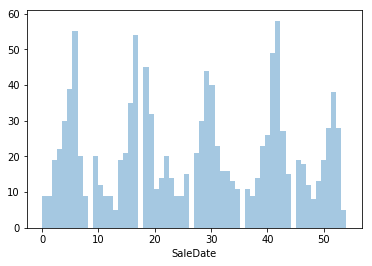

In [133]:
# We store the date with an integer between 0 (Jan 2006) and 59 (Dec 2010)
trainDF["SaleDate"]=trainDF.apply(lambda row : 12*(row.YrSold-2006)+row.MoSold-1,axis=1)
testDF["SaleDate"]=testDF.apply(lambda row : 12*(row.YrSold-2006)+row.MoSold-1,axis=1)
testKaggleDF["SaleDate"]=testKaggleDF.apply(lambda row : 12*(row.YrSold-2006)+row.MoSold-1,axis=1)


#Plot sales by months
sns.distplot(trainDF["SaleDate"],kde=False, bins=60)
plt.show()

We can see that our dataset seems to lack values for the period between February 2010 (49) and June 2010 (53). To make up for those values, we will approximate the corresponding marketHealth values by the average marketHealth of January 2010 and July 2010, weighted by a term encoding the seasonal aspect of sales. 

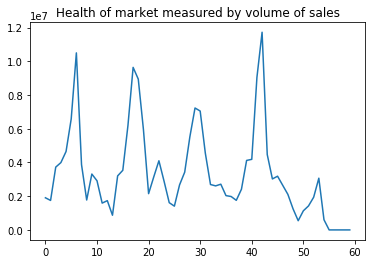

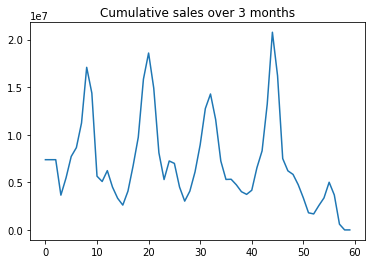

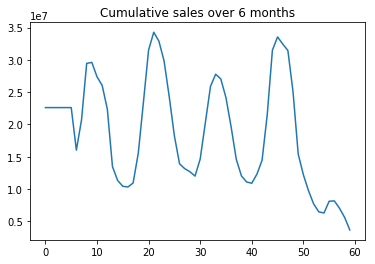

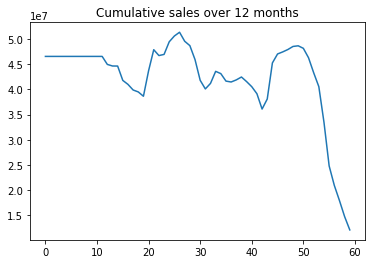

In [134]:
marketHealth = trainDF.groupby(["SaleDate"]).sum()["SalePrice"].to_dict()

newMarketHealth = [0]*60
for i in marketHealth.keys() :
    newMarketHealth[i] = marketHealth[i]
for i in range(49,54):
    newMarketHealth[i] = int((marketHealth[48]/(marketHealth[36]+marketHealth[24]+marketHealth[12]+marketHealth[0])
                          + marketHealth[54]/(marketHealth[42]+marketHealth[30]+marketHealth[18]+marketHealth[6])) * (marketHealth[i-12]+marketHealth[i-24]+marketHealth[i-36]+marketHealth[i-48]) // 2)
plt.plot(newMarketHealth)
plt.title("Health of market measured by volume of sales")
plt.show()

#Plot new graphs
newMarketHealth3 = [0]*60
newMarketHealth6 = [0]*60
newMarketHealth12 = [0]*60
for i in range(60):
    if i<3 :
        newMarketHealth3[i] = sum(newMarketHealth[:3])
        newMarketHealth6[i] = sum(newMarketHealth[:6])
        newMarketHealth12[i] = sum(newMarketHealth[:12])
    elif i<6 : 
        newMarketHealth3[i] = sum(newMarketHealth[i-3:i-1]) #Sellers are supposed not to react to sales in the same month 
        newMarketHealth6[i] = sum(newMarketHealth[:6])
        newMarketHealth12[i] = sum(newMarketHealth[:12])
    elif i<12 :
        newMarketHealth3[i] = sum(newMarketHealth[i-3:i-1])
        newMarketHealth6[i] = sum(newMarketHealth[i-6:i-1])
        newMarketHealth12[i] = sum(newMarketHealth[:12])
    else :
        newMarketHealth3[i] = sum(newMarketHealth[i-3:i-1])
        newMarketHealth6[i] = sum(newMarketHealth[i-6:i-1])
        newMarketHealth12[i] = sum(newMarketHealth[i-12:i-1])
        
#Plot those variables
plt.plot(newMarketHealth3)
plt.title("Cumulative sales over 3 months")
plt.show()
plt.plot(newMarketHealth6)
plt.title("Cumulative sales over 6 months")
plt.show()
plt.plot(newMarketHealth12)
plt.title("Cumulative sales over 12 months")
plt.show()

Here we can see an interesting pattern in the cumulative number of sales over 6 months : there seems some periodic signal with 4 periods corresponding to years from 2006 to 2009. This periodic surge of sales is related to the fact that most sales take place in the 6 months prior to March. What is interesting is that the pattern looks abnormally smaller for 2008 and bigger for 2009. That may well be a sign that the housing market slowdown affected Ames at this time, which would affect the price of houses. The crash seems even more abrupt if we look at sales over a 12-months period.

We can then add those variables as new columns in our dataset.

In [135]:
testKaggleDF["GarageYrBlt"].loc[1132] = testKaggleDF["GarageYrBlt"].mean()

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [136]:
trainDF["marketHealth3"] = trainDF.apply(lambda row : newMarketHealth3[row.SaleDate], axis=1)
trainDF["marketHealth6"] = trainDF.apply(lambda row : newMarketHealth6[row.SaleDate], axis=1)
trainDF["marketHealth12"] = trainDF.apply(lambda row : newMarketHealth12[row.SaleDate], axis=1)
trainDF["marketHealth"] = trainDF.apply(lambda row : newMarketHealth[row.SaleDate], axis=1)

SaleCounts = trainDF["SaleDate"].value_counts(sort=False).values
trainDF["MonthlySale"] = trainDF.apply(lambda row : SaleCounts[row.SaleDate], axis=1)

testDF["marketHealth3"] = testDF.apply(lambda row : newMarketHealth3[row.SaleDate], axis=1)
testDF["marketHealth6"] = testDF.apply(lambda row : newMarketHealth6[row.SaleDate], axis=1)
testDF["marketHealth12"] = testDF.apply(lambda row : newMarketHealth12[row.SaleDate], axis=1)
testDF["marketHealth"] = testDF.apply(lambda row : newMarketHealth[row.SaleDate], axis=1)
testDF["MonthlySale"] = testDF.apply(lambda row : SaleCounts[row.SaleDate], axis=1)

testKaggleDF["marketHealth3"] = testKaggleDF.apply(lambda row : newMarketHealth3[row.SaleDate], axis=1)
testKaggleDF["marketHealth6"] = testKaggleDF.apply(lambda row : newMarketHealth6[row.SaleDate], axis=1)
testKaggleDF["marketHealth12"] = testKaggleDF.apply(lambda row : newMarketHealth12[row.SaleDate], axis=1)
testKaggleDF["marketHealth"] = testKaggleDF.apply(lambda row : newMarketHealth[row.SaleDate], axis=1)
testKaggleDF["MonthlySale"] = testKaggleDF.apply(lambda row : SaleCounts[row.SaleDate], axis=1)

In [137]:
corr_mat = trainDF.drop(["SalePrice","Id"], axis=1).select_dtypes('number').apply(lambda x: x.corr(trainDF.SalePrice))
print(corr_mat.sort_values())

ElectricalBin    -0.243495
KitchenAbvGr     -0.133539
EnclosedPorch    -0.119784
FunctionalS      -0.106462
CondQual1        -0.092647
MiscFeatureBin   -0.092037
CondQual         -0.089571
OverallCond      -0.082572
MSSubClass       -0.075819
YrSold           -0.039827
MiscVal          -0.036874
SaleDate         -0.032218
LowQualFinSF     -0.027067
marketHealth12   -0.023076
BsmtHalfBath     -0.017273
BsmtFinSF2       -0.002910
CondQual2         0.004919
MonthlySale       0.011978
3SsnPorch         0.020831
marketHealth6     0.041039
marketHealth      0.044417
MoSold            0.047005
marketHealth3     0.050458
PoolArea          0.103647
Pool              0.108180
ScreenPorch       0.119904
BedroomAbvGr      0.183825
BsmtUnfSF         0.206069
BsmtFullBath      0.221285
LotFrontage       0.241501
LotArea           0.267581
HalfBath          0.299928
WoodDeckSF        0.315457
OpenPorchSF       0.319390
2ndFlrSF          0.349619
BsmtFinSF1        0.410351
Fireplaces        0.458577
G

We also add the mean value of house sold in the neighborhood in the year of the sale and not the month, because there could have been too few sales in a neighborhood during a given month.

In [138]:
trainDF["MSSubClass"] = trainDF.apply(lambda row : str(row.MSSubClass), axis=1).astype("category")
testDF["MSSubClass"] = testDF.apply(lambda row : str(row.MSSubClass), axis=1).astype("category")
testKaggleDF["MSSubClass"] = testDF.apply(lambda row : str(row.MSSubClass), axis=1).astype("category")

binary_columns = ["Street","Pool","LotShapeBin","LandContourBin"]
date_columns = ["YearBuilt","GarageYrBlt","YearRemodAdd","SaleDate"]
non_ordered_columns = ["FunctionalS", "Exterior1stS","Exterior2ndS","MSZoning","MSSubClass","Alley","LotConfig","LandSlope",
                      "Neighborhood","BldgType","HouseStyle","RoofStyle","RoofMatl","MasVnrType", "Foundation","Heating",
                      "Electrical","GarageType","PavedDrive","Fence","MiscFeature","SaleType","SaleCondition", "LandContour",
                      "Street","CentralAir"]
print(non_ordered_columns)

#Handle Date data
timeFrame = pd.DataFrame({'index': range(185), 'time' : pd.date_range('1/1/1830', freq='Y', periods=185)})
print(timeFrame[:5])
#Transform to associated datetime64 object
trainDF["YearBuilt"] = trainDF.apply(lambda row : timeFrame.iloc[int(row.YearBuilt-1830)], axis=1)
trainDF["YearRemodAdd"] = trainDF.apply(lambda row : timeFrame.iloc[int(row.YearRemodAdd-1830)], axis=1)
trainDF["GarageYrBlt"] = trainDF.apply(lambda row : timeFrame.iloc[int(row.GarageYrBlt-1830)], axis=1)
testDF["YearBuilt"] = testDF.apply(lambda row : timeFrame.iloc[int(row.YearBuilt-1830)], axis=1)
testDF["YearRemodAdd"] = testDF.apply(lambda row : timeFrame.iloc[int(row.YearRemodAdd-1830)], axis=1)
testDF["GarageYrBlt"] = testDF.apply(lambda row : timeFrame.iloc[int(row.GarageYrBlt-1830)], axis=1)

testKaggleDF["YearBuilt"] = testKaggleDF.apply(lambda row : timeFrame.iloc[int(row.YearBuilt-1830)], axis=1)
testKaggleDF["YearRemodAdd"] = testKaggleDF.apply(lambda row : timeFrame.iloc[int(row.YearRemodAdd-1830)], axis=1)
testKaggleDF["GarageYrBlt"] = testKaggleDF.apply(lambda row : timeFrame.iloc[int(row.GarageYrBlt-1830)], axis=1)

saleTimeFrame = pd.DataFrame({'index': range(60), 'saleTime' : pd.date_range('1/1/2006', freq='M', periods=60)})
trainDF["SaleDate"] = trainDF.apply(lambda row : timeFrame.iloc[row.SaleDate],axis=1)
testDF["SaleDate"] = testDF.apply(lambda row : timeFrame.iloc[row.SaleDate],axis=1)
testKaggleDF["SaleDate"] = testKaggleDF.apply(lambda row : timeFrame.iloc[row.SaleDate],axis=1)

#Create new category for missing values in nominal attributes
for column in non_ordered_columns :
    trainDF[column] = trainDF[column].astype('category')
    trainDF[column].cat.add_categories(["Not Relevant"],inplace=True)
    trainDF[column] = trainDF[column].fillna("Not Relevant")
for column in non_ordered_columns :
    testDF[column] = testDF[column].astype('category')
    testDF[column].cat.add_categories(["Not Relevant"],inplace=True)
    testDF[column] = testDF[column].fillna("Not Relevant")
for column in non_ordered_columns :
    testKaggleDF[column] = testKaggleDF[column].astype('category')
    testKaggleDF[column].cat.add_categories(["Not Relevant"],inplace=True)
    testKaggleDF[column] = testKaggleDF[column].fillna("Not Relevant")

['FunctionalS', 'Exterior1stS', 'Exterior2ndS', 'MSZoning', 'MSSubClass', 'Alley', 'LotConfig', 'LandSlope', 'Neighborhood', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'LandContour', 'Street', 'CentralAir']
   index       time
0      0 1830-12-31
1      1 1831-12-31
2      2 1832-12-31
3      3 1833-12-31
4      4 1834-12-31


In [139]:
print(timeFrame[:5])

   index       time
0      0 1830-12-31
1      1 1831-12-31
2      2 1832-12-31
3      3 1833-12-31
4      4 1834-12-31


Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'Exterior1stS',
       'Exterior2ndS', 'FunctionalS'],
      dtype='object')
['ExterCond', 'ExterQual', 'PoolQC', 'Condition1', 'BsmtExposure', 'LotShape', 'Utilities', 'BsmtFinType1', 'Exterior1st', 'BsmtFinType2', 'Exterior2nd', 'BsmtQual', 'GarageCond', 'GarageQual', 'KitchenQual', 'MasVnrArea', 'Functional', 'GarageFinish', 'BsmtCond', '

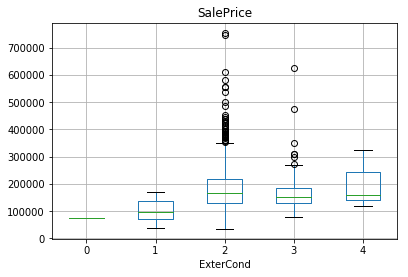

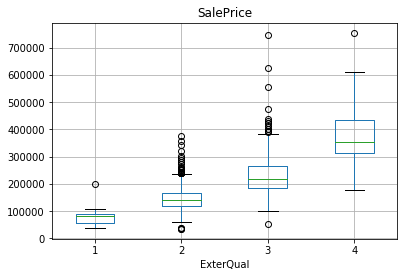

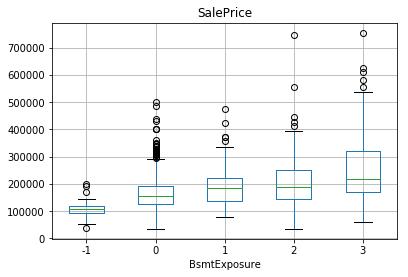

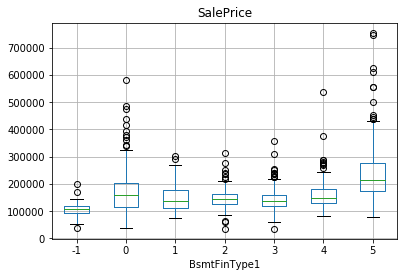

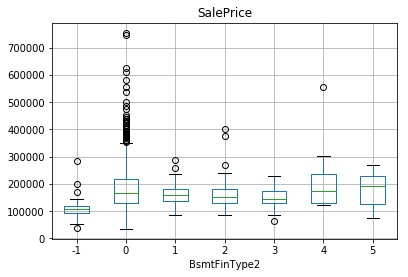

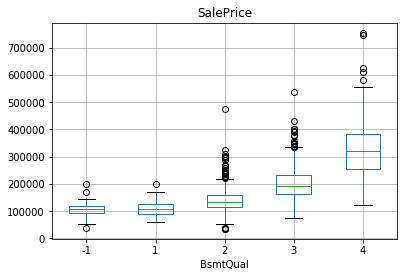

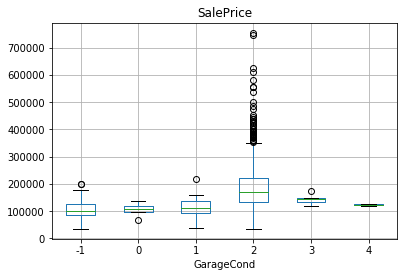

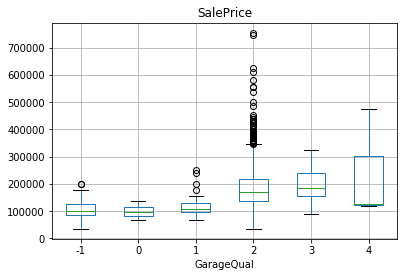

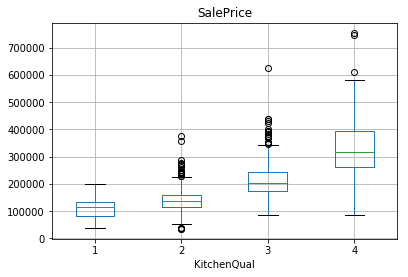

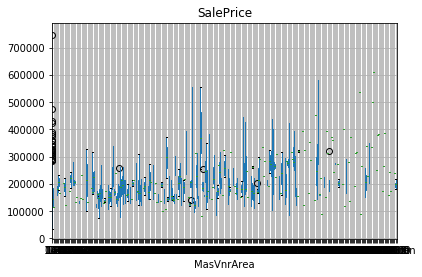

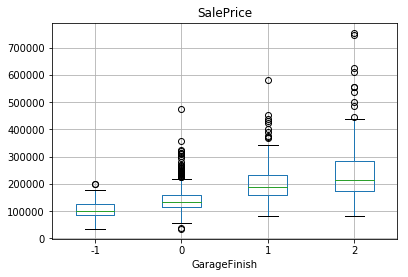

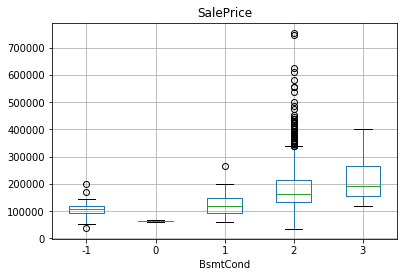

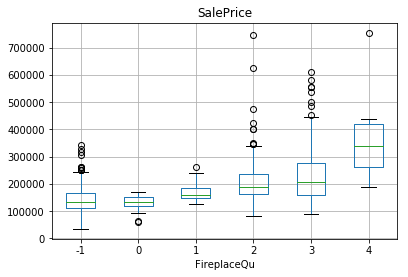

In [140]:
#Transform ordered variables into integer
print(trainDF.select_dtypes("category").columns)
ordered_columns = list(set(trainDF.select_dtypes("category").columns)-set(non_ordered_columns))
print(ordered_columns)

#Remove unnecessary columns
ordered_columns.remove("LotShape")
ordered_columns.remove("Condition1")
ordered_columns.remove("Exterior1st")
ordered_columns.remove("Exterior2nd")
ordered_columns.remove("Condition2")
ordered_columns.remove("Utilities")
ordered_columns.remove("Functional") 
ordered_columns.remove("PoolQC")


print (len(ordered_columns))

print(trainDF["GarageFinish"][:10])
print(trainDF["ExterCond"][:10])

def ordered_variables_transfo(df):
    #Create new category for missing values in ordered attributes
    for column in ordered_columns :
        df[column] = df[column].astype('category')
        df[column].cat.add_categories(["None"],inplace=True)
        df[column] = df[column].fillna("None")

    #Change order of categories to match "semantic order"
    mapping = {"None":-1,"Unf":0,"RFn":1,"Fin":2}
    df["GarageFinish"]=df.GarageFinish.map(mapping)

    mapping = {"None":-1,"Unf":0,"LwQ":1,"Rec":2,"BLQ":3,"ALQ":4,"GLQ":5}
    df["BsmtFinType1"]=df.BsmtFinType1.map(mapping)
    df["BsmtFinType2"]=df.BsmtFinType2.map(mapping)

    mapping = {"None":-1,"No":0,"Mn":1,"Av":2,"Gd":3}
    df["BsmtExposure"]=df.BsmtExposure.map(mapping)

    mapping = {"None":-1,'Po':0,'Fa':1,'TA':2,'Gd':3, 'Ex':4}
    df["BsmtCond"]=df.BsmtCond.map(mapping)
    df["KitchenQual"]=df.KitchenQual.map(mapping)
    df["ExterQual"]=df.ExterQual.map(mapping)
    df["BsmtQual"]=df.BsmtQual.map(mapping)
    df["HeatingQC"]=df.HeatingQC.map(mapping)
    df["FireplaceQu"]=df.FireplaceQu.map(mapping)
    df["GarageCond"]=df.GarageCond.map(mapping)
    df["ExterCond"]=df.ExterCond.map(mapping)
    df["GarageQual"]=df.GarageQual.map(mapping)

ordered_variables_transfo(trainDF)
ordered_variables_transfo(testDF)
ordered_variables_transfo(testKaggleDF)


print(ordered_columns)
print(trainDF["GarageFinish"][:10])
print(trainDF["ExterCond"][:10])

for label in ordered_columns : 
    trainDF.boxplot(column = 'SalePrice', by = label)
    plt.suptitle("")
    plt.show()





In [141]:
from sklearn.ensemble import RandomForestRegressor

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

class StringIndexer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.apply(lambda s: s.cat.codes.replace(
            {-1: len(s.cat.categories)}
        ))

def dateIndex(date):
    if date in saleTimeFrame :
        return saleTimeFrame.index[saletimeFrame["saleTime"]==date]
    if date in timeFrame : 
        return timeFrame.index(timeFrame["time"]==date)

class DateEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        print(X.info())
        res = X
        for column in X.columns :
            if X[column].name=="SaleDate" :
                res[column] = X[column].apply(lambda d : saleTimeFrame.loc[saletimeFrame["saleTime"]==d]["index"])
            else :
                res[column] = X[column].apply(lambda d : timeFrame.loc[timeFrame["time"]==d][index])
        return res
        

transformer = Pipeline([
    ('features', FeatureUnion(n_jobs=1, transformer_list=[
        # Part 1
        ('boolean', Pipeline([
            ('selector', TypeSelector('bool')),
        ])),  # booleans close
        
        ('numericals', Pipeline([
            ('selector', TypeSelector(np.number)),
            ('scaler', StandardScaler()),
        ])),  # numericals close
        
        # Part 2
        ('categoricals', Pipeline([
            ('selector', TypeSelector('category')),
            ('labeler', StringIndexer()),
            ('encoder', OneHotEncoder(handle_unknown='ignore')),
        ])),  # categoricals close
        
        # Part 3
        ('datetimes', Pipeline([
            ('selector', TypeSelector('datetime64')),
            ('labeler', DateEncoder())
        ]))
    ])),  # features close
])  # pipeline close

<div class="">
    <h3>2. Model Selection</h3>
</div>


In [142]:
trainDF = trainDF.drop(["Utilities","LotShape","Electrical","LandContour","Condition1","Condition2","Exterior1st",
              "Exterior2nd", "Functional", "PoolQC","PoolArea","HeatingQC","MoSold","YrSold","Id"],axis=1)
testDF = testDF.drop(["Utilities","LotShape","Electrical","LandContour","Condition1","Condition2","Exterior1st",
              "Exterior2nd", "Functional", "PoolQC","PoolArea","HeatingQC","MoSold","YrSold","Id"],axis=1)
testKaggleDF = testKaggleDF.drop(["Utilities","LotShape","Electrical","LandContour","Condition1","Condition2","Exterior1st",
              "Exterior2nd", "Functional", "PoolQC","PoolArea","HeatingQC","MoSold","YrSold","Id"],axis=1)

X_train, X_test, y_train, y_test = train_test_split(trainDF.drop("SalePrice",axis=1), trainDF["SalePrice"], test_size=0.2, random_state=42)


In [106]:
trainDF[:5]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotConfig,LandSlope,Neighborhood,BldgType,...,ElectricalBin,FunctionalS,Pool,MiscFeatureBin,SaleDate,marketHealth3,marketHealth6,marketHealth12,marketHealth,MonthlySale
0,60,RL,65.0,8450,Pave,Not Relevant,Inside,Gtl,CollgCr,1Fam,...,0,0,0,0,25,6989485,18237189,50635184,1409700,9
1,20,RL,80.0,9600,Pave,Not Relevant,FR2,Gtl,Veenker,1Fam,...,0,0,0,0,16,4076028,10317678,41015203,6199098,35
2,60,RL,68.0,11250,Pave,Not Relevant,Inside,Gtl,CollgCr,1Fam,...,0,0,0,0,32,14282448,25898080,41207809,2692650,16
3,70,RL,60.0,9550,Pave,Not Relevant,Corner,Gtl,Crawfor,1Fam,...,0,0,0,0,1,7379305,22610274,46576224,1748900,9
4,60,RL,84.0,14260,Pave,Not Relevant,FR2,Gtl,NoRidge,1Fam,...,0,0,0,0,35,5304550,24134730,41664184,2034400,11


In [107]:
#Do the same pre-pipeline job on testData

#Do different pipelines with different models, stack them with pre-preprocessing pipeline

#Test predictions to get a feel of models

#Cross-validation to optimize parameters

In [108]:
from sklearn.linear_model import *
from sklearn.ensemble import *

class SparseToDenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.toarray()

lassoCVPredictor = Pipeline([('transform', transformer),
                           ('regressor', LassoCV())])  #Look into more details for parameters


randomForestPredictor = Pipeline([('transform', transformer),
                                   ('regressor', RandomForestRegressor(max_depth=20))])

elasticNetPredictor = Pipeline([('transform', transformer),
                                   ('regressor', ElasticNet())])

gradientBoostingPredictor = Pipeline([('transform', transformer),
                                   ('regressor', GradientBoostingRegressor(random_state=42))])
    
bayesianRidgePredictor = Pipeline([('transform', transformer),
                                   ('densifier', SparseToDenseTransformer()),
                                   ('regressor', BayesianRidge())])

lassoPredictor = Pipeline([('transform', transformer),
                           ('regressor', Lasso())]) 

lassoLarsPredictor = Pipeline([('transform', transformer),
                               ('densifier', SparseToDenseTransformer()),
                               ('regressor', LassoLars())])

linearPredictor = Pipeline([('transform', transformer),
                           ('regressor', LinearRegression())])

from sklearn.gaussian_process import GaussianProcessRegressor

gaussianProcessPredictor = Pipeline([('transform', transformer),
                                     ('densifier', SparseToDenseTransformer()),
                                    ('regressor', GaussianProcessRegressor())])

lassoCVPredictor.fit(X_train ,y_train)
predsLassoCV = lassoCVPredictor.predict(X_test)
print("LassoCV")
print(mt.sqrt(np.mean((np.log(predsLassoCV)-np.log(y_test))**2)))
print("\n")

randomForestPredictor.fit(X_train ,y_train)
print("Random Forest")
predsRandomForest = randomForestPredictor.predict(X_test)
print(mt.sqrt(np.mean((np.log(predsRandomForest)-np.log(y_test))**2)))
print("\n")


elasticNetPredictor.fit(X_train ,y_train)
predsElasticNet = elasticNetPredictor.predict(X_test)
print("ElasticNet")
print(mt.sqrt(np.mean((np.log(predsElasticNet)-np.log(y_test))**2)))
print("\n")


gradientBoostingPredictor.fit(X_train ,y_train)
predsGradientBoosting = gradientBoostingPredictor.predict(X_test)
print("GradientBoosting")
print(mt.sqrt(np.mean((np.log(predsGradientBoosting)-np.log(y_test))**2)))
print("\n")


bayesianRidgePredictor.fit(X_train ,y_train)
predsBayesianRidge = bayesianRidgePredictor.predict(X_test)
print("BayesianRidge")
print(mt.sqrt(np.mean((np.log(predsBayesianRidge)-np.log(y_test))**2)))
print("\n")


lassoPredictor.fit(X_train ,y_train)
print("LassoCV")
predsLasso = lassoPredictor.predict(X_test)
print(mt.sqrt(np.mean((np.log(predsLasso)-np.log(y_test))**2)))
print("\n")

lassoLarsPredictor.fit(X_train ,y_train)
print("LassoLars")
predsLassoLars = lassoLarsPredictor.predict(X_test)
print(mt.sqrt(np.mean((np.log(predsLassoLars)-np.log(y_test))**2)))
print("\n")

gaussianProcessPredictor.fit(X_train ,y_train)
print("GaussianProcess")
predsGaussianProcess = gaussianProcessPredictor.predict(X_test)
print(mt.sqrt(np.mean((np.log(predsGaussianProcess)-np.log(y_test))**2)))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 959 entries, 331 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 1178 to 874
Empty DataFrameNone
LassoCV
0.1770834560088649


<class 'pandas.core.frame.DataFrame'>
Int64Index: 959 entries, 331 to 1127
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log


Random Forest
<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 1178 to 874
Empty DataFrameNone
0.15365746618313245


<class 'pandas.core.frame.DataFrame'>
Int64Index: 959 entries, 331 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 1178 to 874
Empty DataFrameNone
ElasticNet
0.16501129128910677


<class 'pandas.core.frame.DataFrame'>
Int64Index: 959 entries, 331 to 1127
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in log


<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 1178 to 874
Empty DataFrameNone
GradientBoosting
0.14776537661797937


<class 'pandas.core.frame.DataFrame'>
Int64Index: 959 entries, 331 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 1178 to 874
Empty DataFrameNone
BayesianRidge
0.20046941758368744


<class 'pandas.core.frame.DataFrame'>
Int64Index: 959 entries, 331 to 1127
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 84 iterations, i.e. alpha=4.113e+01, with an active set of 80 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 131 iterations, i.e. alpha=2.500e+01, with an active set of 127 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)

LassoCV
<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 1178 to 874
Empty DataFrameNone
0.2512964739358659


<class 'pandas.core.frame.DataFrame'>
Int64Index: 959 entries, 331 to 1127
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 159 iterations, alpha=1.969e+01, previous alpha=1.966e+01, with an active set of 154 regressors.
  ConvergenceWarning)


LassoLars
<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 1178 to 874
Empty DataFrameNone
0.18698671219599847


<class 'pandas.core.frame.DataFrame'>
Int64Index: 959 entries, 331 to 1127
Empty DataFrameNone
GaussianProcess
<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 1178 to 874
Empty DataFrameNone
20.02444631754996


In [109]:
from sklearn.model_selection import GridSearchCV
hyperparameters = {'regressor__alpha_1' : [0.000001, 0.0000001, 0.00001, 0.0001],
                  'regressor__lambda_1' : [0.000001, 0.0000001, 0.00001, 0.0001]}
                  
crossedBayesianRidge = GridSearchCV(bayesianRidgePredictor, hyperparameters, verbose=0, cv=3, scoring='neg_mean_squared_log_error',)
 
# Fit and tune model
crossedBayesianRidge.fit(X_train, y_train)
crossedBayesianRidge.predict(X_test)
predsCrossedBayesianRidge = crossedBayesianRidge.predict(X_test)
print(mt.sqrt(np.mean(np.log(predsCrossedBayesianRidge)-np.log(y_test))**2))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 813 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 331 to 526
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 813 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 331 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 813 to 607
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 331 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 331 to 607
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 319 entries, 180 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 331 to 607
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 813 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 

In [143]:
from sklearn.model_selection import GridSearchCV
lassoLarsPredictor.get_params().keys()
hyperparameters = {'regressor__alpha' : [0.01, 0.1, 1, 5, 10, 100]}
                  
crossedLassoLars = GridSearchCV(lassoLarsPredictor, hyperparameters, cv=3, verbose=0)
 
# Fit and tune model
crossedLassoLars.fit(X_train, y_train)
crossedLassoLars.predict(X_test)
predsCrossedLassoLars = crossedLassoLars.predict(X_test)
print(mt.sqrt(np.mean(np.log(predsCrossedLassoLars)-np.log(y_test))**2))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 813 to 1127
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 126 iterations, i.e. alpha=3.026e+01, with an active set of 122 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 185 iterations, i.e. alpha=1.688e+01, with an active set of 177 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 241 iterations, i.e. alpha=1.089e+01, with an active set of 233 regressors, and the smallest cholesky pivot

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 331 to 526
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 813 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 331 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 813 to 607
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 66 iterations, i.e. alpha=6.402e+01, with an active set of 60 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 116 iterations, i.e. alpha=4.107e+01, with an active set of 110 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 159 iterations, alpha=2.610e+01, previous alpha=2.602e+01

<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 331 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 331 to 607
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 204 iterations, i.e. alpha=1.457e+01, with an active set of 196 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 346 iterations, i.e. alpha=3.057e+00, with an active set of 316 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 346 iterations, i.e. alpha=3.057e+00, with an active set of 316 regressors, and the smallest cholesky pivot

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319 entries, 180 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 331 to 607
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 813 to 1127
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 126 iterations, i.e. alpha=3.026e+01, with an active set of 122 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 185 iterations, i.e. alpha=1.688e+01, with an active set of 177 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 241 iterations, i.e. alpha=1.089e+01, with an active set of 233 regressors, and the smallest cholesky pivot

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 331 to 526
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 813 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 331 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 813 to 607
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 66 iterations, i.e. alpha=6.402e+01, with an active set of 60 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 116 iterations, i.e. alpha=4.107e+01, with an active set of 110 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 159 iterations, alpha=2.610e+01, previous alpha=2.602e+01

<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 331 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 331 to 607
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 204 iterations, i.e. alpha=1.457e+01, with an active set of 196 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 346 iterations, i.e. alpha=3.057e+00, with an active set of 316 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 346 iterations, i.e. alpha=3.057e+00, with an active set of 316 regressors, and the smallest cholesky pivot

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319 entries, 180 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 331 to 607
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 813 to 1127
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 126 iterations, i.e. alpha=3.026e+01, with an active set of 122 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 185 iterations, i.e. alpha=1.688e+01, with an active set of 177 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 241 iterations, i.e. alpha=1.089e+01, with an active set of 233 regressors, and the smallest cholesky pivot

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 331 to 526
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 813 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 331 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 813 to 607
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 66 iterations, i.e. alpha=6.402e+01, with an active set of 60 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 116 iterations, i.e. alpha=4.107e+01, with an active set of 110 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 159 iterations, alpha=2.610e+01, previous alpha=2.602e+01

<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 331 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 331 to 607
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 204 iterations, i.e. alpha=1.457e+01, with an active set of 196 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 346 iterations, i.e. alpha=3.057e+00, with an active set of 316 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 346 iterations, i.e. alpha=3.057e+00, with an active set of 316 regressors, and the smallest cholesky pivot

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319 entries, 180 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 331 to 607
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 813 to 1127
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 126 iterations, i.e. alpha=3.026e+01, with an active set of 122 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 185 iterations, i.e. alpha=1.688e+01, with an active set of 177 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 241 iterations, i.e. alpha=1.089e+01, with an active set of 233 regressors, and the smallest cholesky pivot

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 331 to 526
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 813 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 331 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 813 to 607
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 66 iterations, i.e. alpha=6.402e+01, with an active set of 60 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 116 iterations, i.e. alpha=4.107e+01, with an active set of 110 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 159 iterations, alpha=2.610e+01, previous alpha=2.602e+01

<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 331 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 331 to 607
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 204 iterations, i.e. alpha=1.457e+01, with an active set of 196 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 319 entries, 180 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 331 to 607
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 813 to 1127
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 126 iterations, i.e. alpha=3.026e+01, with an active set of 122 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 185 iterations, i.e. alpha=1.688e+01, with an active set of 177 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 241 iterations, i.e. alpha=1.089e+01, with an active set of 233 regressors, and the smallest cholesky pivot

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 331 to 526
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 813 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 331 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 813 to 607
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 66 iterations, i.e. alpha=6.402e+01, with an active set of 60 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 116 iterations, i.e. alpha=4.107e+01, with an active set of 110 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 159 iterations, alpha=2.610e+01, previous alpha=2.602e+01

<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 331 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 331 to 607
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 204 iterations, i.e. alpha=1.457e+01, with an active set of 196 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 319 entries, 180 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 331 to 607
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 813 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 331 to 526
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 813 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 331 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 813 to 607
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 331 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 331 to 607
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 319 entries, 180 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 84 iterations, i.e. alpha=4.113e+01, with an active set of 80 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 131 iterations, i.e. alpha=2.500e+01, with an active set of 127 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 159 iterations, alpha=1.969e+01, previous alpha=1.966e+01

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 1178 to 874
Empty DataFrameNone
0.0007382557252856303


In [111]:
#Optimization of GradientBoosting
hyperparameters = {'regressor__min_samples_split' : [2, 3, 5, 10],
                  'regressor__min_samples_leaf' : [1, 2, 5, 10],
                  'regressor__max_depth': [2, 3, 5],
                  'regressor__max_features' : [10, 20, 30, 40]
                  }
                  
crossedGradientBoosting = GridSearchCV(gradientBoostingPredictor, hyperparameters, cv=3, verbose=0, scoring='neg_mean_squared_log_error',)
 
# Fit and tune model
crossedGradientBoosting.fit(X_train, y_train)
crossedGradientBoosting.predict(X_test)
predsCrossedGradientBoosting = crossedGradientBoosting.predict(X_test)
print(mt.sqrt(np.mean(np.log(predsCrossedGradientBoosting)-np.log(y_test))**2))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 813 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 331 to 526
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 813 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 331 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 813 to 607
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 331 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 331 to 607
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 319 entries, 180 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 331 to 607
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 813 to 1127
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 

KeyboardInterrupt: 

In [ ]:
#refitting on entire training data using best settings
print(crossedGradientBoosting.best_params_)
crossedGradientBoosting.refit

preds = crossedGradientBoosting.predict(X_test)
print(mt.sqrt(np.mean(np.log(preds)-np.log(y_test))**2))

In [144]:


print(crossedLassoLars.best_params_)
crossedLassoLars.refit

preds = crossedLassoLars.predict(X_test)
print(mt.sqrt(np.mean(np.log(preds)-np.log(y_test))**2))

{'regressor__alpha': 10}
<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 1178 to 874
Empty DataFrameNone
0.0007382557252856303


In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='neg_mean_squared_log_error', n_iter = 100, cv = 5, verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
searchedRandomForestPredictor = Pipeline([('transform', transformer),
                                   ('regressor', rf_random)])
searchedRandomForestPredictor.fit(X_train, y_train)
preds = searchedRandomForestPredictor.predict(X_test)
print(mt.sqrt(np.mean(np.log(preds)-np.log(y_test))**2))

In [145]:
crossedLassoLars.fit(trainDF.drop("SalePrice",axis=1),trainDF["SalePrice"])
predsTestKaggle = crossedLassoLars.predict(testKaggleDF)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 400 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 74 iterations, i.e. alpha=5.784e+01, with an active set of 68 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 127 iterations, i.e. alpha=3.152e+01, with an active set of 117 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 139 iterations, i.e. alpha=2.725e+01, with an active set of 127 regressors, and the smallest cholesky pivot e

<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 400 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 1199
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 167 iterations, i.e. alpha=2.228e+01, with an active set of 155 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 215 iterations, i.e. alpha=1.529e+01, with an active set of 197 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 249 iterations, i.e. alpha=1.152e+01, with an active set of 227 regressors, and the smallest cholesky pivot

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 400 to 800
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 800
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 157 iterations, i.e. alpha=2.524e+01, with an active set of 147 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 210 iterations, i.e. alpha=1.735e+01, with an active set of 200 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 210 iterations, i.e. alpha=1.735e+01, with an active set of 200 regressors, and the smallest cholesky pivot

<class 'pandas.core.frame.DataFrame'>
Int64Index: 399 entries, 801 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 800
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 400 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 74 iterations, i.e. alpha=5.784e+01, with an active set of 68 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 127 iterations, i.e. alpha=3.152e+01, with an active set of 117 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 139 iterations, i.e. alpha=2.725e+01, with an active set of 127 regressors, and the smallest cholesky pivot e

<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 400 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 1199
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 167 iterations, i.e. alpha=2.228e+01, with an active set of 155 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 215 iterations, i.e. alpha=1.529e+01, with an active set of 197 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 249 iterations, i.e. alpha=1.152e+01, with an active set of 227 regressors, and the smallest cholesky pivot

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 400 to 800
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 800
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 157 iterations, i.e. alpha=2.524e+01, with an active set of 147 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 210 iterations, i.e. alpha=1.735e+01, with an active set of 200 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 210 iterations, i.e. alpha=1.735e+01, with an active set of 200 regressors, and the smallest cholesky pivot

<class 'pandas.core.frame.DataFrame'>
Int64Index: 399 entries, 801 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 800
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 400 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 74 iterations, i.e. alpha=5.784e+01, with an active set of 68 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 127 iterations, i.e. alpha=3.152e+01, with an active set of 117 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 139 iterations, i.e. alpha=2.725e+01, with an active set of 127 regressors, and the smallest cholesky pivot e

<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 400 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 1199
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 167 iterations, i.e. alpha=2.228e+01, with an active set of 155 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 215 iterations, i.e. alpha=1.529e+01, with an active set of 197 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 249 iterations, i.e. alpha=1.152e+01, with an active set of 227 regressors, and the smallest cholesky pivot

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 400 to 800
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 800
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 157 iterations, i.e. alpha=2.524e+01, with an active set of 147 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 210 iterations, i.e. alpha=1.735e+01, with an active set of 200 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 210 iterations, i.e. alpha=1.735e+01, with an active set of 200 regressors, and the smallest cholesky pivot

<class 'pandas.core.frame.DataFrame'>
Int64Index: 399 entries, 801 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 800
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 400 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 74 iterations, i.e. alpha=5.784e+01, with an active set of 68 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 127 iterations, i.e. alpha=3.152e+01, with an active set of 117 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 139 iterations, i.e. alpha=2.725e+01, with an active set of 127 regressors, and the smallest cholesky pivot e

<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 400 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 1199
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 167 iterations, i.e. alpha=2.228e+01, with an active set of 155 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 215 iterations, i.e. alpha=1.529e+01, with an active set of 197 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 249 iterations, i.e. alpha=1.152e+01, with an active set of 227 regressors, and the smallest cholesky pivot

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 400 to 800
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 800
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 157 iterations, i.e. alpha=2.524e+01, with an active set of 147 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 210 iterations, i.e. alpha=1.735e+01, with an active set of 200 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 210 iterations, i.e. alpha=1.735e+01, with an active set of 200 regressors, and the smallest cholesky pivot

<class 'pandas.core.frame.DataFrame'>
Int64Index: 399 entries, 801 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 800
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 400 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 74 iterations, i.e. alpha=5.784e+01, with an active set of 68 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 127 iterations, i.e. alpha=3.152e+01, with an active set of 117 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 139 iterations, i.e. alpha=2.725e+01, with an active set of 127 regressors, and the smallest cholesky pivot e

<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 400 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 1199
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 167 iterations, i.e. alpha=2.228e+01, with an active set of 155 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 215 iterations, i.e. alpha=1.529e+01, with an active set of 197 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 249 iterations, i.e. alpha=1.152e+01, with an active set of 227 regressors, and the smallest cholesky pivot

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 400 to 800
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 800
Empty DataFrameNone


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 157 iterations, i.e. alpha=2.524e+01, with an active set of 147 regressors, and the smallest cholesky pivot element being 2.107e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 210 iterations, i.e. alpha=1.735e+01, with an active set of 200 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 210 iterations, i.e. alpha=1.735e+01, with an active set of 200 regressors, and the smallest cholesky pivot

<class 'pandas.core.frame.DataFrame'>
Int64Index: 399 entries, 801 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 800
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 400 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 400 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 400 to 800
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 800
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 399 entries, 801 to 1199
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 88 iterations, i.e. alpha=3.643e+01, with an active set of 86 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 148 iterations, i.e. alpha=1.978e+01, with an active set of 146 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 148 iterations, i.e. alpha=1.978e+01, with an active set of 146 regressors, and the smallest cholesky pivot e

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Empty DataFrameNone


In [ ]:
predsTest[:10]
print(salesByDate["Neighborhood"][:5])

In [ ]:
#refitting on entire training data using best settings
print(crossedLassoLars.best_params_)
crossedLassoLars.refit

preds = crossedLassoLars.predict(X_test)
print(mt.sqrt(np.mean(np.log(preds)-np.log(y_test))**2))

testDFBis = pd.read_csv(base + 'test1.csv')

testDFBis["SaleDate"]=testDFBis.apply(lambda row : 12*(row.YrSold-2006)+row.MoSold-1,axis=1)
testDFBis["marketHealth3"] = testDFBis.apply(lambda row : newMarketHealth3[row.SaleDate], axis=1)
testDFBis["marketHealth6"] = testDFBis.apply(lambda row : newMarketHealth6[row.SaleDate], axis=1)
testDFBis["marketHealth12"] = testDFBis.apply(lambda row : newMarketHealth12[row.SaleDate], axis=1)
testDFBis["marketHealth"] = testDFBis.apply(lambda row : newMarketHealth[row.SaleDate], axis=1)
testDFBis["MonthlySale"] = testDFBis.apply(lambda row : SaleCounts[row.SaleDate], axis=1)
testDFBis["meanPriceAround"] = testDFBis.apply(lambda x : salesByDate.loc[salesByDate["YrSold"]==x.YrSold].loc[salesByDate["Neighborhood"]==x.Neighborhood],axis=1)
                                                                                                            
testDFBis["MSSubClass"] = testDFBis.apply(lambda row : str(row.MSSubClass), axis=1).astype("category")
#Handle Date data
timeFrame = pd.DataFrame({'index': range(185), 'time' : pd.date_range('1/1/1830', freq='Y', periods=185)})
print(timeFrame[:5])
#Transform to associated datetime64 object

testDFBis["YearBuilt"] = testDFBis.apply(lambda row : timeFrame.iloc[int(row.YearBuilt-1830)], axis=1)
testDFBis["YearRemodAdd"] = testDFBis.apply(lambda row : timeFrame.iloc[int(row.YearRemodAdd-1830)], axis=1)
testDFBis["GarageYrBlt"] = testDFBis.apply(lambda row : timeFrame.iloc[int(row.GarageYrBlt-1830)], axis=1)

saleTimeFrame = pd.DataFrame({'index': range(60), 'saleTime' : pd.date_range('1/1/2006', freq='M', periods=60)})
testDFBis["SaleDate"] = testDFBis.apply(lambda row : timeFrame.iloc[row.SaleDate],axis=1)

#Create new category for missing values in nominal attributes
for column in non_ordered_columns :
    testDFBis[column] = testDFBis[column].astype('category')
    testDFBis[column].cat.add_categories(["Not Relevant"],inplace=True)
    testDFBis[column] = testDFBis[column].fillna("Not Relevant")
    
ordered_variables_transfo(testDFBis)
nominal_variables_transfo(testDFBis)
testDFBis = testDFBis.drop(["Utilities","LotShape","Electrical","LandContour","Condition1","Condition2","Exterior1st",
              "Exterior2nd", "Functional", "PoolQC","PoolArea","HeatingQC","MoSold","YrSold"],axis=1)
print(testDFBis["Id"].describe())
predsTest = crossedLassoLars.predict(testDFBis.drop("Id",axis=1))
import csv
csvData = []

for i in range (len(predsTest)):
    csvData.append([testDFBis.iloc[i]["Id"],predsTest[i]])
print(csvData[:5])
with open('submission.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

In [ ]:
trainSize = 959
print("Size of training set : "+str(trainSize))
for label in y_train.columns : 
    value_count = y_train[label].count()
    if y_train[label].count() != trainSize :
        print("  Number of missing values in "+label+" in training dataset : "+str(trainSize-y_train[label].count()))
print("\n")

In [ ]:
print(len(y_train))

In [ ]:
print(len(testDFBis))
# Compute number of missing values per attribute in the testing set
testSize = 1459
print("Size of testing set : "+str(testSize))
for label in testDFBis.columns : 
    value_count = testDFBis[label].count()
    if testDFBis[label].count() != testSize :
        print("  Number of missing values in "+label+" in testing dataset : "+str(testSize-testDFBis[label].count()))

In [ ]:
print(len(trainDFBis["Id"]))

In [ ]:
print(trainDFBis.info())

In [ ]:
predsTest = crossedLassoLars.predict(testDF)
print(mt.sqrt(np.mean(np.log(predsTest)-np.log(y_test))**2))
testDFTer = pd.read_csv(base+'test.csv')
import csv
csvData = []

for i in range (len(predsTest)):
    csvData.append([testDFTer.iloc[i]["Id"],predsTest[i]])
print(csvData[:5])
with open('submission.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

In [147]:
import csv
csvData = []
testKaggleDF = pd.read_csv(base+ 'test_kaggle.csv')

for i in range (len(predsTestKaggle)):
    csvData.append([testKaggleDF.iloc[i]["Id"],predsTestKaggle[i]])
print(csvData[:5])
with open('submission.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)

csvFile.close()

[[1461, 127259.65612074031], [1462, 177010.90986695688], [1463, 174189.88804283412], [1464, 191270.97334800946], [1465, 217326.4835803039]]
